In [2]:
import uuid, sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import math
import random

from sklearn import metrics
from scipy import stats
from collections import Counter

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
print(torch.cuda.get_device_name(0))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW

torch.manual_seed(0)

from accelerate import Accelerator

import matplotlib.pyplot as plt
import seaborn as sns

Tesla V100-SXM2-32GB


/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'Could not load this library: /work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [3]:
SEED = 0
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
import wandb
wandb.login()

wandb: Currently logged in as: s232958 (s232958-danmarks-tekniske-universitet-dtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
os.chdir("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts")
# print(os.getcwd())

print("PyTorch:", torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

PyTorch: 2.9.1+cu128
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [6]:
# Model parameters
memory_verbose = False
use_wandb = True # Used to track loss in real-time without printing
model_save_steps = 1

embedding_dimension = 1152 # 1280 | 960 | 1152
number_of_recycles = 2
padding_value = -5000

In [7]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=1152, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value
        self.embed_dimension = embed_dimension

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init

        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)  # For residual additions

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input, padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input, padding_value=self.padding_value)
 
        # Initialize residual states
        pep_emb = pep_input.clone()
        prot_emb = prot_input.clone()
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            pep_emb = pep_emb + pep_cross  
            prot_emb = prot_emb + prot_cross

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding))
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding))
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1)
        
        return logits

    def training_step(self, batch, device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        logits = self.forward(embedding_pep, embedding_prot)
        
        # compute on TRAIN fold
        # pos = (binder_labels == 1).sum()
        # neg = (binder_labels == 0).sum()
        # pos_weight = torch.tensor([neg / max(1, pos)], device=device)
        
        loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
        # loss = F.binary_cross_entropy_with_logits(logits, binder_labels, pos_weight=pos_weight)

        return loss
    
    def validation_step(self, batch, device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        with torch.no_grad():
            logits = self.forward(embedding_pep, embedding_prot)
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
    
        return float(loss), logits, binder_labels

In [8]:
## Output path
trained_model_dir = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts"

# ## Training variables
runID = uuid.uuid4()

def print_mem_consumption():
    # 1. Total memory available on the GPU (device 0)
    t = torch.cuda.get_device_properties(0).total_memory
    # 2. How much memory PyTorch has *reserved* from CUDA
    r = torch.cuda.memory_reserved(0)
    # 3. How much of that reserved memory is actually *used* by tensors
    a = torch.cuda.memory_allocated(0)
    # 4. Reserved but not currently allocated (so “free inside PyTorch’s pool”)
    f = r - a

    print("Total memory: ", t/1e9)      # total VRAM in GB
    print("Reserved memory: ", r/1e9)   # PyTorch’s reserved pool in GB
    print("Allocated memory: ", a//1e9) # actually in use (integer division)
    print("Free memory: ", f/1e9)       # slack in the reserved pool in GB
print_mem_consumption()

Total memory:  34.072559616
Reserved memory:  0.0
Allocated memory:  0.0
Free memory:  0.0


#### Loading data frame

In [9]:
### Loading the dataset
interaction_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal.csv", index_col = 0).reset_index(drop=True).drop(columns = ["target_id"]).rename(columns={
    "A_seq" : "binder_seq",
    "B_seq" : "target_seq"
})

all_targets = interaction_df.target_id_mod.unique()
binder_nonbinder = interaction_df.binder.value_counts()
target_binder_nonbinder_Dict = dict(interaction_df.groupby("target_id_mod")["binder"].value_counts())
sorted_items = sorted(target_binder_nonbinder_Dict.items(), key=lambda kv: kv[1], reverse=True)

# %%
# Annotating each observation with a weight corresponding to whether it is considered a binder or not

### Weights for binder/non-binders
N_bins = len(interaction_df["binder"].value_counts())
pr_class_uniform_weight = 1 / N_bins
pr_class_weight_informed_with_size_of_bins = pr_class_uniform_weight  / interaction_df["binder"].value_counts()
pr_class_weight_informed_with_size_of_bins = pr_class_weight_informed_with_size_of_bins.to_dict()
interaction_df["class_weight"] = interaction_df.binder.apply(lambda x: pr_class_weight_informed_with_size_of_bins[x])
# binder_nonbinder_weights_Dict = dict(zip(interaction_df["target_binder_ID"], interaction_df["class_weight"]))

### Weights for target
N_bins = len(interaction_df["target_id_mod"].value_counts())
pr_class_uniform_weight = 1 / N_bins
pr_class_weight_informed_with_size_of_bins = pr_class_uniform_weight  / interaction_df["target_id_mod"].value_counts()
pr_class_weight_informed_with_size_of_bins = pr_class_weight_informed_with_size_of_bins.to_dict()
interaction_df["target_weight"] = interaction_df.target_id_mod.apply(lambda x: pr_class_weight_informed_with_size_of_bins[x])

### Combined weights
interaction_df["combined_weight"] = (interaction_df["class_weight"]+interaction_df["target_weight"])/2
interaction_df

,binder_chain,target_chains,binder,binder_seq,target_seq,target_id_mod,target_binder_ID,class_weight,target_weight,combined_weight
0,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1,0.000159,0.000631,0.000395
1,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1,0.000159,0.000029,0.000094
2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2,0.000159,0.000029,0.000094
3,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3,0.000159,0.000029,0.000094
4,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4,0.000159,0.000029,0.000094
...,...,...,...,...,...,...,...,...,...,...
3527,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62,0.000159,0.000947,0.000553
3528,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63,0.000159,0.000947,0.000553
3529,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64,0.000159,0.000947,0.000553
3530,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65,0.000159,0.000947,0.000553


# 5-fold CV training + weighting of samples

In [10]:
clusters = [
    ["VirB8"], 
    ["FGFR2"], 
    ["IL7Ra"], 
    ["InsulinR"],
    ["EGFR", "EGFR_2", "EGFR_3"],     # keep together
    ["SARS_CoV2_RBD"], 
    ["Pdl1"], 
    ["TrkA"], 
    ["IL10Ra"],
    ["LTK"], 
    ["Mdm2"],
    ["sntx", "sntx_2"],               # keep together
    ["IL2Ra"]]

random.Random(0).shuffle(clusters)
folds = np.array_split(np.array(clusters, dtype=object), 5)   # list of np arrays
targets_folds = []
for f in folds:
    flat = []
    for group in f:
        flat.extend(group)
    targets_folds.append(flat)

def build_cv_splits(targets_folds):
    val_folds, train_folds = [], []
    K = len(targets_folds)
    for i in range(K):
        val_targets = list(targets_folds[i])  # copy
        train_targets = [t for j, fold in enumerate(targets_folds) if j != i for t in fold]
        val_folds.append(val_targets)
        train_folds.append(train_targets)
    return val_folds, train_folds

val_folds, train_folds = build_cv_splits(targets_folds)
cv_splits = list(zip(val_folds, train_folds))

In [11]:
for idx in range(len(cv_splits)):
    val_targets = cv_splits[idx][0]
    vals = len(interaction_df[interaction_df.target_id_mod.isin(val_targets)])
    trains = len(interaction_df) - vals
    print(f"Fold {idx+1} : training instances : {trains}, validation instances : {vals}")

Fold 1 : training instances : 1280, validation instances : 2252
Fold 2 : training instances : 3213, validation instances : 319
Fold 3 : training instances : 3265, validation instances : 267
Fold 4 : training instances : 2999, validation instances : 533
Fold 5 : training instances : 3371, validation instances : 161


In [12]:
for idx in range(len(cv_splits)):
    val_targets = cv_splits[idx][0]
    train_targets = cv_splits[idx][1]
    print(f"Fold {idx+1} : validation targets : {val_targets}")

Fold 1 : validation targets : ['FGFR2', 'Mdm2', 'LTK']
Fold 2 : validation targets : ['SARS_CoV2_RBD', 'sntx', 'sntx_2', 'IL7Ra']
Fold 3 : validation targets : ['InsulinR', 'TrkA', 'IL10Ra']
Fold 4 : validation targets : ['EGFR', 'EGFR_2', 'EGFR_3', 'VirB8']
Fold 5 : validation targets : ['IL2Ra', 'Pdl1']


In [13]:
interaction_df.loc[interaction_df.target_id_mod.isin(cv_splits[1][1])].binder.value_counts()

binder
False    2876
True      337
Name: count, dtype: int64

#### Creating separate targets/ binder dataframes

In [14]:
# Targets df
target_df = interaction_df[["target_id_mod","target_seq"]].rename(columns={"target_seq":"sequence", "target_id_mod" : "ID"})
target_df["seq_len"] = target_df["sequence"].apply(len)
target_df = target_df.drop_duplicates(subset=["ID","sequence"])
target_df = target_df.set_index("ID")

# Binders df
binder_df = interaction_df[["target_binder_ID","binder_seq", "binder", "class_weight", "target_weight", "combined_weight"]].rename(columns={"binder_seq":"sequence", "target_binder_ID" : "ID", "binder" : "label"})
binder_df["seq_len"] = binder_df["sequence"].apply(len)
binder_df = binder_df.set_index("ID")

# Interaction Dict
interaction_Dict = dict(enumerate(zip(interaction_df["target_id_mod"], interaction_df["target_binder_ID"]), start=1))

In [15]:
class CLIP_meta_analysis_dataset(Dataset):

    def __init__(self, sequence_df, esm_encoding_paths, embedding_dim=1152, padding_value=-5000):

        super(CLIP_meta_analysis_dataset, self).__init__()

        self.sequence_df = sequence_df # target/binder_df
        self.max_length = sequence_df["seq_len"].max()+2
        self.sequence_df["index_num"] = np.arange(len(self.sequence_df))
        # print(self.sequence_df)
        self.esm_encoding_paths = esm_encoding_paths
        num_samples = len(self.sequence_df)
        
        self.x = torch.full((num_samples, self.max_length, embedding_dim), padding_value, dtype=torch.float32)

        self.accessions = self.sequence_df.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        
        # Load embeddings into the pre-allocated tensor
        all_acc_list = self.accessions
        all_acc_loaded_list = []

        iterator = tqdm(all_acc_list, position=0, leave=True, total=num_samples, desc="# Reading in ESM-embeddings from folder")
        for i, accession in enumerate(iterator):
            npy_path = os.path.join(esm_encoding_paths, f"{accession}.npy")
            try:
                embd = np.load(npy_path)[0]
                assert (embd.shape[0] == self.sequence_df.loc[accession].seq_len+2)
                length_to_pad = self.max_length - len(embd)
                if length_to_pad > 0:
                    zero_padding = np.ones((length_to_pad, embd.shape[1])) * padding_value
                    padded_array = np.concatenate((embd, zero_padding), axis=0)
                else:
                    padded_array = embd[:self.max_length] 
                self.x[i] = torch.tensor(padded_array, dtype=torch.float32)
                all_acc_loaded_list.append(accession)
            except FileNotFoundError as e:
                raise FileNotFoundError(f"Embedding file {accession}.npy not found.")
            
        missing = sorted(set(all_acc_list) - set(all_acc_loaded_list))
        if missing:
            raise FileNotFoundError(
                f"Missing {len(missing)} embedding files in '{esm_encoding_paths}'. "
                f"Examples: {missing}")
          
    def __len__(self):
        return int(self.x.shape[0])

    def __getitem__(self, idx):
        return self.x[idx]
    
    # add a helper:
    def get_by_name(self, name: str):
        return self.x[self.name_to_row[name]]

targets_dataset = CLIP_meta_analysis_dataset(target_df, esm_encoding_paths="/work3/s232958/data/meta_analysis/embeddings_esmC_targets", embedding_dim=1152)
binders_dataset = CLIP_meta_analysis_dataset(binder_df, esm_encoding_paths="/work3/s232958/data/meta_analysis/embeddings_esmC_binders", embedding_dim=1152)

# Reading in ESM-embeddings from folder: 100%|█████████████████████████████████████| 3532/3532 [00:07<00:00, 450.99it/s]


In [16]:
# checking if _get_by_name function gives the same output as index used
print(torch.equal(targets_dataset[0], targets_dataset.get_by_name("VirB8")))
print(torch.equal(binders_dataset[0], binders_dataset.get_by_name("VirB8_1")))

True
True


### Loading pretrained model for finetuning

In [17]:
ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
# print(list(checkpoint["model_state_dict"]))
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MiniCLIP_w_transformer_crossattn()
model.load_state_dict(checkpoint['model_state_dict'])
torch.cuda.empty_cache()  # frees cached blocks (not live tensors)
device = torch.device("cuda:0")
model.to(device)
# model.train()

MiniCLIP_w_transformer_crossattn(
  (transformerencoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
    )
    (linear1): Linear(in_features=1152, out_features=1152, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1152, out_features=1152, bias=True)
    (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
  )
  (prot_embedder): Sequential(
    (0): Linear(in_features=1152, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=32

### Creating function for loading training/ vlaidation datasets
#### creating class for pairing minibinder_emb, target_emb, label

In [18]:
def binder_to_target_name(bname: str) -> str:
    parts = bname.split("_")
    if bname.startswith("SARS"):
        return "SARS_CoV2_RBD"
    if len(parts) == 3:
        return f"{parts[0]}_{parts[1]}"
    return parts[0]

def binder_target_label(targets_dataset, binders_dataset, binder_ids, interaction_df, stack=True):
    listof_bindertargetlabel = []
    for bname in binder_ids:
        tname = binder_to_target_name(bname)
        b_emb = binders_dataset.get_by_name(bname)
        t_emb = targets_dataset.get_by_name(tname)
        s = interaction_df.loc[interaction_df['target_binder_ID'] == bname, 'binder']
        lbl = torch.tensor(float(s.iat[0]), dtype=torch.float32)
        listof_bindertargetlabel.append((b_emb, t_emb, lbl))

    return listof_bindertargetlabel

ALL_btl_list = binder_target_label(targets_dataset, binders_dataset, interaction_df["target_binder_ID"].tolist(), interaction_df)
# ALL_btl_list.__len__()
# ALL_btl_list.__getitem__(0)

binders = torch.stack([torch.as_tensor(b) for b,_,_ in ALL_btl_list])   # [N, L, D]
targets = torch.stack([torch.as_tensor(t) for _,t,_ in ALL_btl_list])   # [N, L, D]
labels  = torch.tensor([float(y) for _,_,y in ALL_btl_list], dtype=torch.float32)  # [N]

ALL_btl = TensorDataset(binders, targets, labels)
# ALL_btl[0]

In [19]:
### Combined weights (boost positives, reduce number of FGFR2 binder)
multipliers = []
for name in interaction_df["target_id_mod"]:
    if name == "FGFR2":
        multipliers.append(1)
    else:
        multipliers.append(5)
interaction_df["target_weight_FGFR2_reduced"] = interaction_df["target_weight"] * multipliers

### Combined weights
# interaction_df["combined_weight"] = (interaction_df["class_weight"]+interaction_df["target_weight"])/2

### Combined weights (boost positives)
multipliers = []
for binder in interaction_df["binder"]:
    if binder == False:
        multipliers.append(1)
    else:
        multipliers.append(2)
interaction_df["combined_weight_boost_pos"] = ((interaction_df["class_weight"]+interaction_df["target_weight_FGFR2_reduced"])/2) * multipliers

In [20]:
interaction_df

,binder_chain,target_chains,binder,binder_seq,target_seq,target_id_mod,target_binder_ID,class_weight,target_weight,combined_weight,target_weight_FGFR2_reduced,combined_weight_boost_pos
0,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1,0.000159,0.000631,0.000395,0.003157,0.001658
1,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1,0.000159,0.000029,0.000094,0.000029,0.000094
2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2,0.000159,0.000029,0.000094,0.000029,0.000094
3,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3,0.000159,0.000029,0.000094,0.000029,0.000094
4,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4,0.000159,0.000029,0.000094,0.000029,0.000094
...,...,...,...,...,...,...,...,...,...,...,...,...
3527,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62,0.000159,0.000947,0.000553,0.004735,0.002447
3528,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63,0.000159,0.000947,0.000553,0.004735,0.002447
3529,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64,0.000159,0.000947,0.000553,0.004735,0.002447
3530,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65,0.000159,0.000947,0.000553,0.004735,0.002447


In [21]:
assert labels.ndim == 1 and labels.shape[0] == binders.shape[0]
assert binders.dtype == targets.dtype
# assert binders.shape == targets.shape

In [22]:
u = interaction_df[['binder', 'target_id_mod', 'combined_weight_boost_pos']].drop_duplicates(subset=['target_id_mod', 'binder'])
print(u.sort_values('target_id_mod').to_string(index=False))
# or as a dict:
weight_map = u.set_index('target_id_mod')['combined_weight_boost_pos'].to_dict()

 binder target_id_mod  combined_weight_boost_pos
   True          EGFR                   0.003720
  False          EGFR                   0.001300
   True        EGFR_2                   0.002314
  False        EGFR_2                   0.000597
   True        EGFR_3                   0.079404
  False         FGFR2                   0.000094
   True         FGFR2                   0.001308
   True        IL10Ra                   0.015483
  False        IL10Ra                   0.007182
   True         IL2Ra                   0.006014
  False         IL2Ra                   0.002447
  False         IL7Ra                   0.000993
   True         IL7Ra                   0.003106
   True      InsulinR                   0.003950
  False      InsulinR                   0.001415
  False           LTK                   0.004814
   True           LTK                   0.010748
  False          Mdm2                   0.001707
   True          Mdm2                   0.004534
   True          Pdl

In [23]:
train_targets = cv_splits[1][1]
g = torch.Generator().manual_seed(SEED)

class PairListDataset(torch.utils.data.Dataset):
    # examples: list of (binder_emb, target_emb, label)
    # target_ids: parallel list of target_id_mod (same order)
    def __init__(self, examples, target_ids):
        assert len(examples) == len(target_ids)
        self.examples = examples
        self.target_ids = list(map(str, target_ids))

    def __len__(self): return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        return (torch.as_tensor(b, dtype=torch.float32),
                torch.as_tensor(t, dtype=torch.float32),
                torch.tensor(float(y), dtype=torch.float32),
                self.target_ids[idx])  # <- keep the id

train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
# train_weights_combined_boosted = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_boost_pos"].tolist()

train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
train_target_ids = interaction_df.loc[train_idx, "target_id_mod"].astype(str).tolist()
train_binders_ds = PairListDataset([ALL_btl[idx] for idx in train_idx], target_ids=train_target_ids)

train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=len(train_binders_ds), replacement=True, generator = g)
train_loader   = DataLoader(train_binders_ds,  batch_size=20, sampler=train_sampler)

for bi, batch in enumerate(train_loader):
    _, _, labels, ids = batch
    c = Counter(ids)
    print(f"Batch {bi}: {dict(c)}  | positives={int(labels.sum().item())} / {labels.numel()}")
    if bi == 10: break  # first 5 batches

Batch 0: {'EGFR_2': 3, 'FGFR2': 11, 'Mdm2': 2, 'EGFR_3': 1, 'VirB8': 1, 'TrkA': 1, 'InsulinR': 1}  | positives=8 / 20
Batch 1: {'FGFR2': 12, 'TrkA': 1, 'InsulinR': 1, 'LTK': 2, 'Mdm2': 1, 'EGFR_2': 2, 'VirB8': 1}  | positives=11 / 20
Batch 2: {'FGFR2': 8, 'Mdm2': 3, 'Pdl1': 1, 'IL2Ra': 2, 'InsulinR': 2, 'EGFR_2': 1, 'TrkA': 2, 'VirB8': 1}  | positives=12 / 20
Batch 3: {'FGFR2': 11, 'IL2Ra': 1, 'VirB8': 2, 'EGFR': 2, 'Mdm2': 2, 'Pdl1': 1, 'LTK': 1}  | positives=8 / 20
Batch 4: {'EGFR_2': 1, 'FGFR2': 15, 'TrkA': 1, 'Mdm2': 1, 'VirB8': 1, 'InsulinR': 1}  | positives=5 / 20
Batch 5: {'FGFR2': 12, 'EGFR_2': 4, 'Mdm2': 2, 'VirB8': 1, 'TrkA': 1}  | positives=10 / 20
Batch 6: {'FGFR2': 11, 'Pdl1': 3, 'IL10Ra': 1, 'EGFR_2': 1, 'Mdm2': 1, 'EGFR_3': 1, 'InsulinR': 1, 'VirB8': 1}  | positives=13 / 20
Batch 7: {'FGFR2': 17, 'EGFR': 1, 'EGFR_2': 1, 'VirB8': 1}  | positives=10 / 20
Batch 8: {'Mdm2': 3, 'FGFR2': 10, 'InsulinR': 1, 'EGFR_2': 3, 'IL2Ra': 1, 'TrkA': 1, 'IL10Ra': 1}  | positives=11 / 20
B

### Training loop

In [24]:
def batch(iterable, n=20):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]


all_hist = []


class TrainWrapper_MetaAnal():

    def __init__(self, model, training_loader, validation_loader, test_dataset,
                 optimizer, EPOCHS, runID, device, test_indexes_for_auROC=None,
                 auROC_batch_size=18, model_save_steps=False, model_save_path=False,
                 v=False, wandb_tracker=False, split_id=None):

        self.model = model
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.EPOCHS = EPOCHS
        self.wandb_tracker = wandb_tracker
        self.model_save_steps = model_save_steps
        self.verbose = v
        self.split_id = split_id
        self.best_vloss = 1e09
        self.optimizer = optimizer
        self.runID = runID
        self.trained_model_dir = model_save_path
        self.print_frequency_loss = 1
        self.device = device
        self.test_indexes_for_auROC = test_indexes_for_auROC
        self.auROC_batch_size = auROC_batch_size
        self.test_dataset = test_dataset

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0
        # for batch_data in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):
        for batch_data in self.training_loader:
            if batch_data[0].size(0) == 1:
                continue
            self.optimizer.zero_grad()
            loss = self.model.training_step(batch_data, self.device)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()

        return running_loss / max(1, len(self.training_loader))

    def calc_auroc_aupr_on_indexes(self, model, validation_dataset, batch_size=20, pad_value=-5000.0):

        model.eval()
        all_scores, all_labels = [], []
        batched_data = batch(validation_dataset, n=batch_size)

        with torch.no_grad():
            # for one_batch in tqdm(batched_data, total= len(validation_dataset)/batch_size, desc="Calculating AUC"):
            for one_batch in batched_data:

                embedding_pep, embedding_prot, binder_labels = batch
                embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

                logits = model.forward(binders, targets)

                all_scores.extend(logits.tolist())
                all_labels.extend(binder_labels.tolist())

        all_scores = np.array(all_scores, dtype=np.float64)
        all_labels = np.array(all_labels, dtype=np.int64)

        fpr, tpr, _ = metrics.roc_curve(all_labels, all_scores)
        auroc = metrics.roc_auc_score(all_labels, all_scores)
        aupr  = metrics.average_precision_score(all_labels, all_scores)

        return auroc, aupr, fpr, tpr

    def validate(self, dataloader, indexes_for_auc=False, auROC_dataset=False):

        self.model.eval()
        running_loss, n_loss = 0.0, 0
        all_scores, all_labels = [], []

        with torch.no_grad():
            # for batch_data in tqdm(dataloader, total=len(dataloader), desc="Validation"):
            for batch_data in dataloader:

                loss, logits, labels = self.model.validation_step(batch_data, self.device)

                running_loss += float(loss)
                n_loss += 1
                all_scores.append(logits.detach().float().cpu())
                all_labels.append(labels.detach().long().cpu())

        val_loss = running_loss / max(1, n_loss)

        if all_scores:
            scores = torch.cat(all_scores).numpy()
            labs   = torch.cat(all_labels).numpy()
            val_auroc = metrics.roc_auc_score(labs, scores)
            val_aupr  = metrics.average_precision_score(labs, scores)
        else:
            scores = np.array([], dtype=np.float64)   # <-- define when empty
            labs   = np.array([], dtype=np.int64)
            val_auroc = float("nan")
            val_aupr  = float("nan")

        return val_loss, val_auroc, val_aupr, scores, labs

    def _plot_val_histories(self, hist, epochs_to_show=("first","middle","last")):

        if not hist:
            return

        epochs = [e for (e,_,_) in hist]
        choose = []
        if "first" in epochs_to_show:
            choose.append(epochs[0])
        if "middle" in epochs_to_show:
            choose.append(epochs[len(epochs)//2])
        if "last" in epochs_to_show:
            choose.append(epochs[-1])
        choose = sorted(set(choose))

        # grid of histograms
        ncols = len(choose)
        fig, axs = plt.subplots(1, ncols, figsize=(6*ncols, 4), sharey=True)
        if ncols == 1: axs = [axs]

        for ax, ek in zip(axs, choose):
            # fetch data for epoch ek
            for (e, s, y) in hist:
                if e == ek:
                    scores, labs = s, y
                    break
            pos = scores[labs == 1]
            neg = scores[labs == 0]

            ax.hist(neg, bins=40, density=True, alpha=0.6, label="neg (y=0)")
            ax.hist(pos, bins=40, density=True, alpha=0.6, label="pos (y=1)")
            ax.axvline(0.0, ls="--", color="k", alpha=0.6)  # decision boundary (logit 0)
            ax.set_title(f"Val logits @ epoch {ek}")
            ax.set_xlabel("logit (z)"); ax.set_ylabel("density")
            ax.legend()

        plt.tight_layout(); plt.show()

        # median gap curve
        ep, gaps = [], []
        for e, s, y in hist:
            pos = s[y==1]; neg = s[y==0]
            if pos.size and neg.size:
                gaps.append(np.median(pos) - np.median(neg))
            else:
                gaps.append(np.nan)
            ep.append(e)

        plt.figure(figsize=(6,4))
        plt.plot(ep, gaps, marker="o")
        plt.xlabel("epoch"); plt.ylabel("median(pos logit) - median(neg logit)")
        plt.title("Val logit median gap over epochs")
        plt.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

    def train_model(self):

        if self.verbose:
            print(f"Training model {str(self.runID)}")

        # Pre-training snapshot
        val_loss, val_auroc, val_aupr, scores, labs = self.validate(dataloader=self.validation_loader, indexes_for_auc=self.test_indexes_for_auROC, auROC_dataset=self.test_dataset)

        if self.verbose:
            print(
                f'Before training - Val Loss {val_loss:.4f} | '
                f'Val AUROC {val_auroc if val_auroc==val_auroc else float("nan"):.4f} | '
                f'Val AUPR {val_aupr if val_aupr==val_aupr else float("nan"):.4f}'
            )

        if self.wandb_tracker:
            log_items = {
                "Val Loss": val_loss,
                "Val AUROC": val_auroc,
                "Val AUPR": val_aupr,
            }
            self.wandb_tracker.log(log_items)

        hist = []

        # --- Epoch loop ---
        # for epoch in tqdm(range(1, self.EPOCHS + 1), total=self.EPOCHS, desc="Epochs"):
        for epoch in range(1, self.EPOCHS + 1):

            torch.cuda.empty_cache()

            train_loss = self.train_one_epoch()
            val_loss, val_auroc, val_aupr, scores, labs  = self.validate(dataloader=self.validation_loader, indexes_for_auc=self.test_indexes_for_auROC, auROC_dataset=self.test_dataset)
            hist.append((epoch, scores, labs))

            if self.verbose and (epoch % self.print_frequency_loss == 0):
                print(
                    f'EPOCH {epoch} - Train Loss {train_loss:.4f} | '
                    f'Val Loss {val_loss:.4f} | Val AUROC {val_auroc if val_auroc==val_auroc else float("nan"):.4f} | '
                    f'Val AUPR {val_aupr if val_aupr==val_aupr else float("nan"):.4f}'
                )

            if scores.size and labs.size:
                pos_mask = labs == 1
                neg_mask = labs == 0
                median_pos = float(np.median(scores[pos_mask])) if pos_mask.any() else float("nan")
                median_neg = float(np.median(scores[neg_mask])) if neg_mask.any() else float("nan")
                gap = median_pos - median_neg if np.isfinite(median_pos) and np.isfinite(median_neg) else float("nan")
            else:
                pos_med = neg_med = gap = float("nan")

            if self.wandb_tracker:
                log_items = {
                    "Train Loss": train_loss,
                    "Val Loss": val_loss,
                    "Val AUROC": val_auroc,
                    "Val AUPR": val_aupr,
                    "val_pos_median_logit": median_pos,
                    "val_neg_median_logit": median_neg,
                    "val_logit_gap": gap,
                }
                # remove Nones so W&B doesn't complain
                log_items = {k: v for k, v in log_items.items() if v is not None}
                self.wandb_tracker.log(log_items, step=epoch)

        # after training, you can plot locally:
        all_hist.append(hist)
        self._plot_val_histories(hist)

        if self.wandb_tracker:
            self.wandb_tracker.finish()

## class weighting (12 epochs)

Training model 289a7027-81b5-4ea5-bdba-7ec07779d650
Before training - Val Loss 1.1936 | Val AUROC 0.5581 | Val AUPR 0.1265
EPOCH 1 - Train Loss 0.6232 | Val Loss 0.6401 | Val AUROC 0.6606 | Val AUPR 0.2141
EPOCH 2 - Train Loss 0.4842 | Val Loss 0.6182 | Val AUROC 0.6707 | Val AUPR 0.2239
EPOCH 3 - Train Loss 0.3888 | Val Loss 0.7039 | Val AUROC 0.6730 | Val AUPR 0.2340
EPOCH 4 - Train Loss 0.3116 | Val Loss 0.3832 | Val AUROC 0.6730 | Val AUPR 0.2558
EPOCH 5 - Train Loss 0.2200 | Val Loss 0.3701 | Val AUROC 0.6431 | Val AUPR 0.2269
EPOCH 6 - Train Loss 0.1592 | Val Loss 0.4060 | Val AUROC 0.6248 | Val AUPR 0.2382
EPOCH 7 - Train Loss 0.1055 | Val Loss 0.3808 | Val AUROC 0.5998 | Val AUPR 0.2151
EPOCH 8 - Train Loss 0.0835 | Val Loss 0.3998 | Val AUROC 0.6359 | Val AUPR 0.2312
EPOCH 9 - Train Loss 0.0760 | Val Loss 0.4013 | Val AUROC 0.6380 | Val AUPR 0.2519
EPOCH 10 - Train Loss 0.0381 | Val Loss 0.4080 | Val AUROC 0.6286 | Val AUPR 0.2453
EPOCH 11 - Train Loss 0.0233 | Val Loss 0.4170

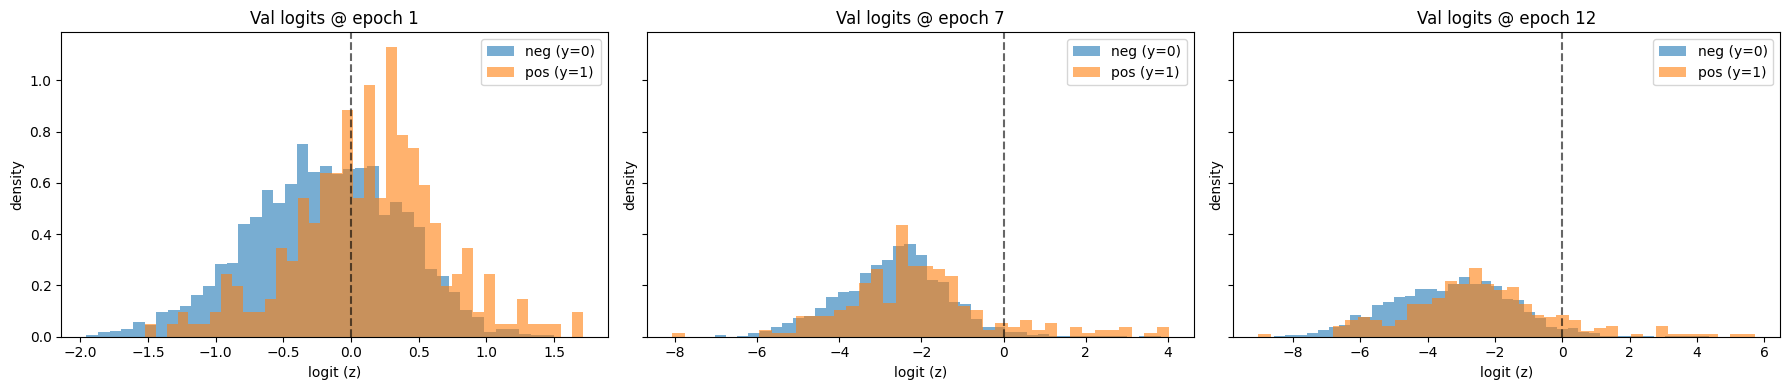

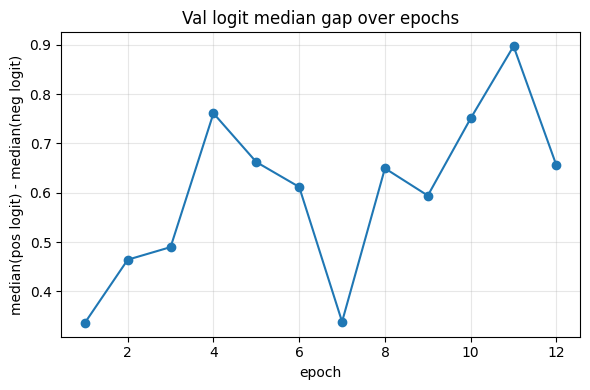

Train Loss,█▆▅▄▃▃▂▂▂▁▁▁
Val AUPR,▁▆▆▇█▆▇▆▇█▇▆▅
Val AUROC,▁▇███▆▅▄▆▆▅▆▄
Val Loss,█▃▃▄▁▁▁▁▁▁▁▁▁
val_logit_gap,▁▃▃▆▅▄▁▅▄▆█▅
val_neg_median_logit,███▅▂▂▃▂▂▁▁▂
val_pos_median_logit,▇▇█▅▂▁▂▁▁▁▁▂
Train Loss,0.02137
Val AUPR,0.20936
Val AUROC,0.61289
Val Loss,0.41633


Training model 289a7027-81b5-4ea5-bdba-7ec07779d650
Before training - Val Loss 1.1206 | Val AUROC 0.6058 | Val AUPR 0.2369
EPOCH 1 - Train Loss 0.6146 | Val Loss 0.5158 | Val AUROC 0.5415 | Val AUPR 0.1839
EPOCH 2 - Train Loss 0.5351 | Val Loss 0.5544 | Val AUROC 0.5951 | Val AUPR 0.2180
EPOCH 3 - Train Loss 0.4639 | Val Loss 0.5939 | Val AUROC 0.5992 | Val AUPR 0.2331
EPOCH 4 - Train Loss 0.3985 | Val Loss 0.5360 | Val AUROC 0.6047 | Val AUPR 0.2367
EPOCH 5 - Train Loss 0.2819 | Val Loss 0.6004 | Val AUROC 0.5842 | Val AUPR 0.2143
EPOCH 6 - Train Loss 0.1962 | Val Loss 0.6865 | Val AUROC 0.5701 | Val AUPR 0.2036
EPOCH 7 - Train Loss 0.1373 | Val Loss 0.7551 | Val AUROC 0.5119 | Val AUPR 0.1858
EPOCH 8 - Train Loss 0.0921 | Val Loss 0.7060 | Val AUROC 0.5451 | Val AUPR 0.1990
EPOCH 9 - Train Loss 0.0455 | Val Loss 0.8486 | Val AUROC 0.4762 | Val AUPR 0.1655
EPOCH 10 - Train Loss 0.0489 | Val Loss 0.7581 | Val AUROC 0.4975 | Val AUPR 0.1756
EPOCH 11 - Train Loss 0.0400 | Val Loss 0.8167

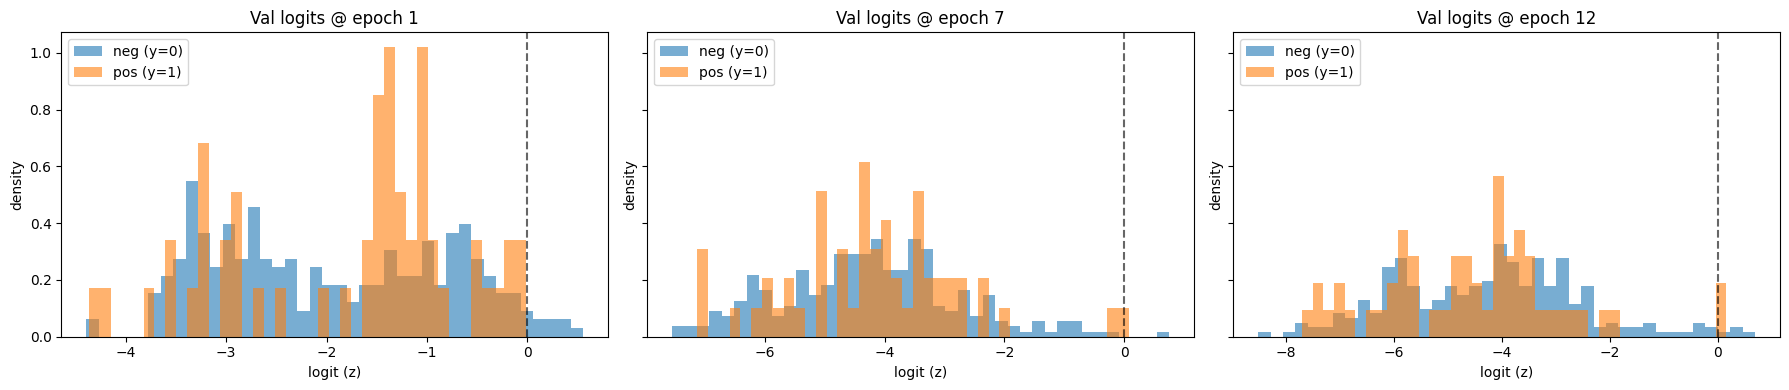

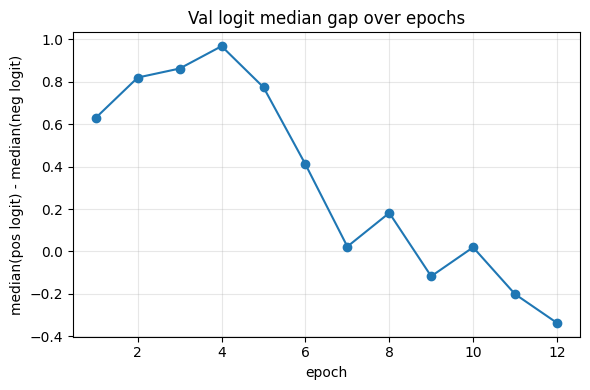

Train Loss,█▇▆▅▄▃▂▂▁▁▁▁
Val AUPR,█▃▆██▆▅▄▅▂▃▁▁
Val AUROC,█▅███▇▆▄▅▂▃▁▁
Val Loss,█▁▁▂▁▂▃▄▃▅▄▄▅
val_logit_gap,▆▇▇█▇▅▃▄▂▃▂▁
val_neg_median_logit,██▇▅▅▄▂▃▁▃▂▂
val_pos_median_logit,███▆▅▅▂▃▁▃▂▂
Train Loss,0.02009
Val AUPR,0.15471
Val AUROC,0.44322
Val Loss,0.83159


Training model 289a7027-81b5-4ea5-bdba-7ec07779d650
Before training - Val Loss 0.7167 | Val AUROC 0.6781 | Val AUPR 0.1806
EPOCH 1 - Train Loss 0.6057 | Val Loss 0.9105 | Val AUROC 0.6022 | Val AUPR 0.1665
EPOCH 2 - Train Loss 0.5233 | Val Loss 0.5016 | Val AUROC 0.5853 | Val AUPR 0.1711
EPOCH 3 - Train Loss 0.4591 | Val Loss 0.5831 | Val AUROC 0.6617 | Val AUPR 0.1872
EPOCH 4 - Train Loss 0.4073 | Val Loss 0.7367 | Val AUROC 0.5906 | Val AUPR 0.1586
EPOCH 5 - Train Loss 0.3117 | Val Loss 0.7792 | Val AUROC 0.5253 | Val AUPR 0.1514
EPOCH 6 - Train Loss 0.2159 | Val Loss 0.8178 | Val AUROC 0.6009 | Val AUPR 0.1793
EPOCH 7 - Train Loss 0.1616 | Val Loss 0.6044 | Val AUROC 0.5883 | Val AUPR 0.1700
EPOCH 8 - Train Loss 0.1034 | Val Loss 0.7007 | Val AUROC 0.5808 | Val AUPR 0.1476
EPOCH 9 - Train Loss 0.0722 | Val Loss 0.5859 | Val AUROC 0.5671 | Val AUPR 0.1543
EPOCH 10 - Train Loss 0.0498 | Val Loss 0.6742 | Val AUROC 0.5846 | Val AUPR 0.1470
EPOCH 11 - Train Loss 0.0486 | Val Loss 0.7043

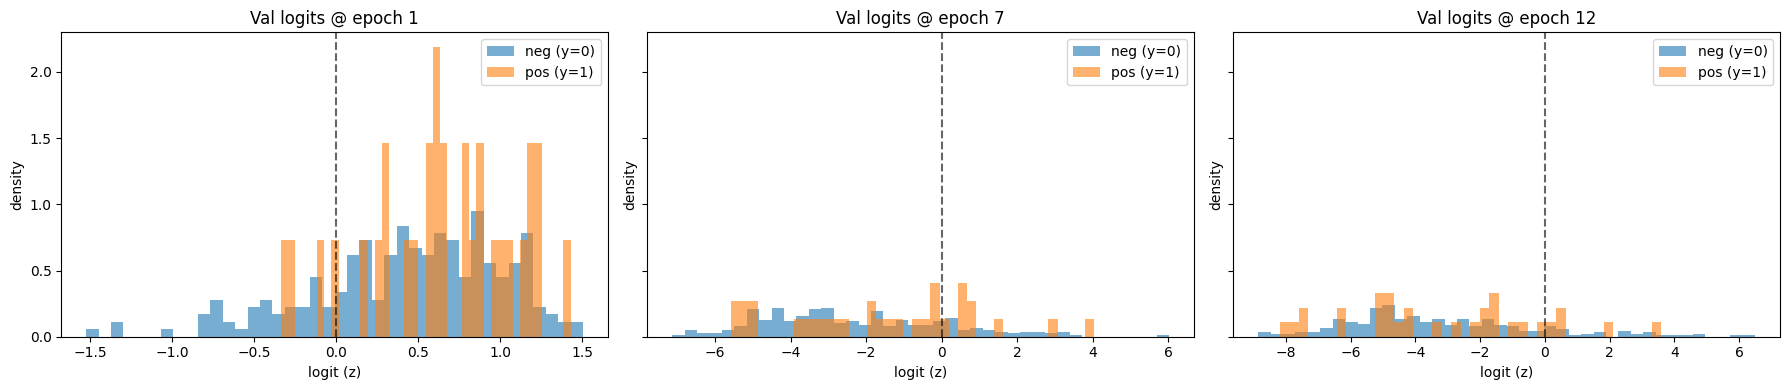

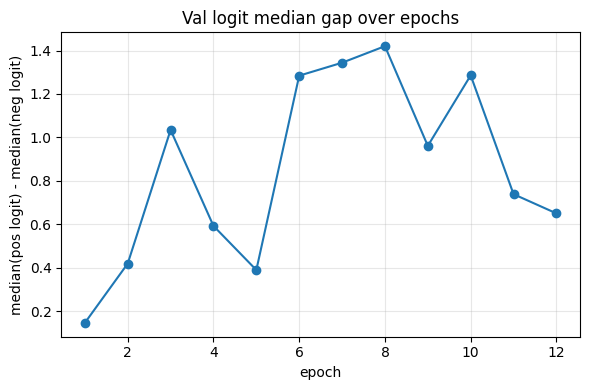

Train Loss,█▇▆▆▄▃▃▂▂▁▁▁
Val AUPR,▇▅▆█▄▄▇▆▃▄▃▃▁
Val AUROC,█▅▄▇▄▁▅▄▄▃▄▁▁
Val Loss,▅█▁▂▅▆▆▃▄▂▄▄▅
val_logit_gap,▁▃▆▃▂▇██▅▇▄▄
val_neg_median_logit,█▆▆▇▆▆▃▄▂▃▁▂
val_pos_median_logit,█▆▇▇▆█▅▆▂▄▁▁
Train Loss,0.02475
Val AUPR,0.1306
Val AUROC,0.5231
Val Loss,0.73406


Training model 289a7027-81b5-4ea5-bdba-7ec07779d650
Before training - Val Loss 0.5645 | Val AUROC 0.5779 | Val AUPR 0.1244
EPOCH 1 - Train Loss 0.6221 | Val Loss 0.7970 | Val AUROC 0.5612 | Val AUPR 0.0859
EPOCH 2 - Train Loss 0.5401 | Val Loss 0.7057 | Val AUROC 0.5466 | Val AUPR 0.0808
EPOCH 3 - Train Loss 0.4848 | Val Loss 0.5230 | Val AUROC 0.5756 | Val AUPR 0.0802
EPOCH 4 - Train Loss 0.4315 | Val Loss 0.9027 | Val AUROC 0.5484 | Val AUPR 0.0743
EPOCH 5 - Train Loss 0.3762 | Val Loss 0.5746 | Val AUROC 0.5104 | Val AUPR 0.0780
EPOCH 6 - Train Loss 0.2595 | Val Loss 0.5857 | Val AUROC 0.4986 | Val AUPR 0.0690
EPOCH 7 - Train Loss 0.1800 | Val Loss 0.7078 | Val AUROC 0.5141 | Val AUPR 0.0722
EPOCH 8 - Train Loss 0.1400 | Val Loss 0.5623 | Val AUROC 0.4706 | Val AUPR 0.0733
EPOCH 9 - Train Loss 0.0918 | Val Loss 0.4012 | Val AUROC 0.4738 | Val AUPR 0.0939
EPOCH 10 - Train Loss 0.0520 | Val Loss 0.4823 | Val AUROC 0.4361 | Val AUPR 0.0606
EPOCH 11 - Train Loss 0.0472 | Val Loss 0.5409

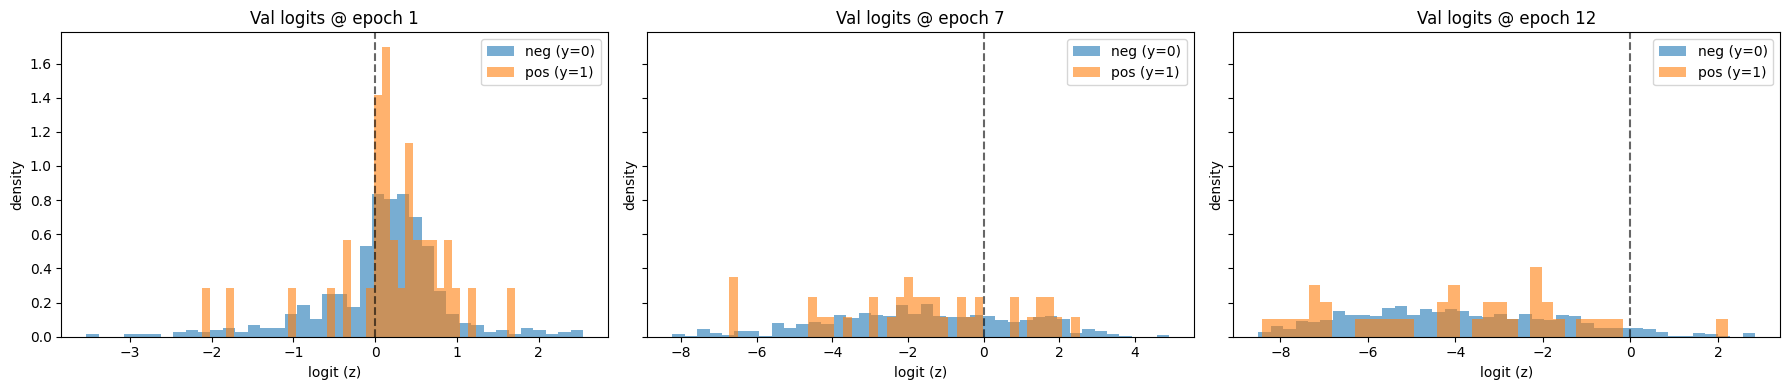

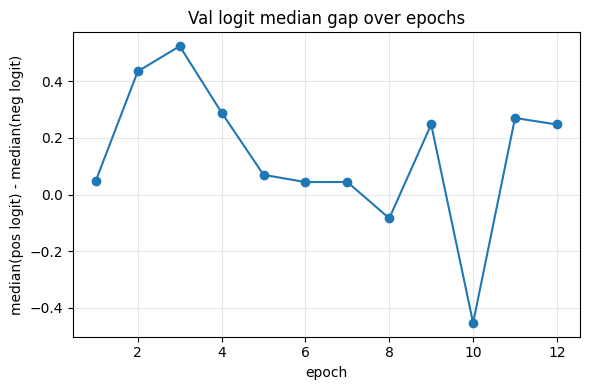

Train Loss,█▇▆▆▅▄▃▂▂▁▁▁
Val AUPR,█▄▃▃▃▃▂▂▂▅▁▂▃
Val AUROC,█▇▆█▇▅▄▅▃▃▁▃▄
Val Loss,▃▇▅▃█▃▄▅▃▁▂▃▁
val_logit_gap,▅▇█▆▅▅▅▄▆▁▆▆
val_neg_median_logit,█▇▆█▆▆▅▅▄▄▃▁
val_pos_median_logit,██▆█▆▅▅▄▄▃▃▁
Train Loss,0.03864
Val AUPR,0.07727
Val AUROC,0.49962
Val Loss,0.42003


Training model 289a7027-81b5-4ea5-bdba-7ec07779d650
Before training - Val Loss 0.8068 | Val AUROC 0.5047 | Val AUPR 0.1241
EPOCH 1 - Train Loss 0.6076 | Val Loss 0.7715 | Val AUROC 0.5225 | Val AUPR 0.1761
EPOCH 2 - Train Loss 0.5400 | Val Loss 0.5846 | Val AUROC 0.4984 | Val AUPR 0.1599
EPOCH 3 - Train Loss 0.4653 | Val Loss 0.4503 | Val AUROC 0.5031 | Val AUPR 0.1858
EPOCH 4 - Train Loss 0.4157 | Val Loss 0.5489 | Val AUROC 0.5008 | Val AUPR 0.1207
EPOCH 5 - Train Loss 0.3284 | Val Loss 0.3895 | Val AUROC 0.5202 | Val AUPR 0.1384
EPOCH 6 - Train Loss 0.2276 | Val Loss 0.4498 | Val AUROC 0.5031 | Val AUPR 0.1657
EPOCH 7 - Train Loss 0.1732 | Val Loss 0.5104 | Val AUROC 0.4545 | Val AUPR 0.1328
EPOCH 8 - Train Loss 0.1155 | Val Loss 0.4802 | Val AUROC 0.5198 | Val AUPR 0.1475
EPOCH 9 - Train Loss 0.0820 | Val Loss 0.5430 | Val AUROC 0.5319 | Val AUPR 0.1236
EPOCH 10 - Train Loss 0.0632 | Val Loss 0.5301 | Val AUROC 0.5719 | Val AUPR 0.1325
EPOCH 11 - Train Loss 0.0311 | Val Loss 0.5731

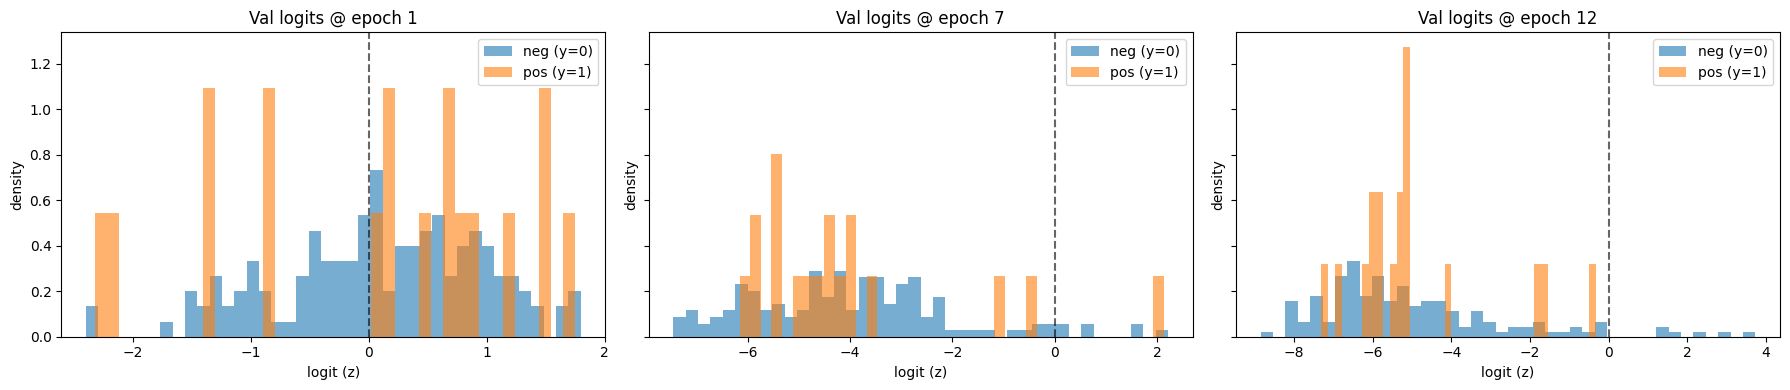

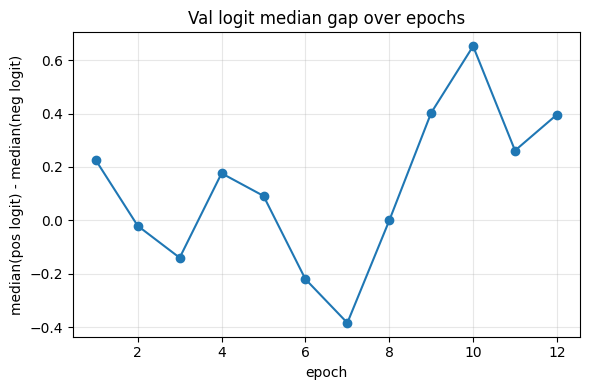

Train Loss,█▇▆▆▅▃▃▂▂▂▁▁
Val AUPR,▁▇▅█▁▃▆▂▄▁▂▂▁
Val AUROC,▄▅▄▄▄▅▄▁▅▆██▆
Val Loss,█▇▄▂▄▁▂▃▃▄▃▄▅
val_logit_gap,▅▃▃▅▄▂▁▄▆█▅▆
val_neg_median_logit,█▇▆▆▅▄▃▃▂▂▁▁
val_pos_median_logit,█▇▆▆▄▃▂▂▂▂▁▁
Train Loss,0.02012
Val AUPR,0.12524
Val AUROC,0.54468
Val Loss,0.60694


In [24]:
batch_size = 10
learning_rate = 2e-5
EPOCHS = 12
g = torch.Generator().manual_seed(SEED)

# login once (env var preferred)
if use_wandb:
    import wandb
    wandb.login()

class PairListDataset(Dataset):
    def __init__(self, examples, weights=None):
        self.examples = examples
        self.weights = weights  # optional per-sample weights (list/array)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        b = torch.as_tensor(b, dtype=torch.float32)
        t = torch.as_tensor(t, dtype=torch.float32)
        y = torch.tensor(float(y), dtype=torch.float32)
        if self.weights is None:
            return b, t, y
        else:
            w = torch.tensor(float(self.weights[idx]), dtype=torch.float32)
            return b, t, y, w

ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
# model.train()

for i in range(len(cv_splits)):
    # NEW model per split
    model = MiniCLIP_w_transformer_crossattn()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # validation
    val_targets = cv_splits[i][0]
    val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
    val_binders = [ALL_btl[idx] for idx in val_idx]
    val_binders = PairListDataset(val_binders)

    # training
    train_targets = cv_splits[i][1]

    train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
    train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
    train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
    train_weights_combined_boost_positives = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_boost_pos"].tolist()

    train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
    train_binders = [ALL_btl[idx] for idx in train_idx]
    train_binders = PairListDataset(train_binders)

    # loaders
    ### no weighting
    # train_loader   = DataLoader(train_binders, batch_size=20, shuffle=True)

    ### class weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### target weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_target, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting (boost positives)
    train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=train_binders.__len__(), replacement=True, generator = g)
    train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)
    
    val_loader   = DataLoader(val_binders,   batch_size=20, shuffle=False, drop_last = False)

    # accelerator
    accelerator = Accelerator()
    device = accelerator.device
    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    # wandb
    if use_wandb:
        run = wandb.init(
            project="FT_on_meta_weighting",
            name=f"split{i+1}_class_weight",
            group="cv_splits",
            config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
                    "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
        )
        wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
    else:
        run = None

    # train
    training_wrapper = TrainWrapper_MetaAnal(
        model=model,
        training_loader=train_loader,
        validation_loader=val_loader,
        test_dataset=val_binders,   # ok if you truly want “full val”
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        runID=runID,
        device=device,
        model_save_steps=model_save_steps,
        model_save_path=trained_model_dir,
        v=True,
        wandb_tracker=run,
        split_id=i+1
    )
    training_wrapper.train_model()

    # cleanup between splits
    if use_wandb:
        wandb.finish()
    del training_wrapper, model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    try:
        accelerator.free_memory()
    except AttributeError:
        pass

## target weighting (12 epochs)

Training model 289a7027-81b5-4ea5-bdba-7ec07779d650
Before training - Val Loss 1.1936 | Val AUROC 0.5581 | Val AUPR 0.1265
EPOCH 1 - Train Loss 0.3667 | Val Loss 0.3431 | Val AUROC 0.6815 | Val AUPR 0.2553
EPOCH 2 - Train Loss 0.2593 | Val Loss 0.3371 | Val AUROC 0.6578 | Val AUPR 0.2452
EPOCH 3 - Train Loss 0.1970 | Val Loss 0.3296 | Val AUROC 0.6566 | Val AUPR 0.2617
EPOCH 4 - Train Loss 0.2290 | Val Loss 0.3561 | Val AUROC 0.6443 | Val AUPR 0.2086
EPOCH 5 - Train Loss 0.2009 | Val Loss 0.3650 | Val AUROC 0.5757 | Val AUPR 0.2345
EPOCH 6 - Train Loss 0.1678 | Val Loss 0.3797 | Val AUROC 0.6349 | Val AUPR 0.1853
EPOCH 7 - Train Loss 0.1595 | Val Loss 0.3652 | Val AUROC 0.6323 | Val AUPR 0.2450
EPOCH 8 - Train Loss 0.1586 | Val Loss 0.3709 | Val AUROC 0.6046 | Val AUPR 0.2325
EPOCH 9 - Train Loss 0.1294 | Val Loss 0.4051 | Val AUROC 0.6311 | Val AUPR 0.2108
EPOCH 10 - Train Loss 0.1097 | Val Loss 0.4224 | Val AUROC 0.5695 | Val AUPR 0.2447
EPOCH 11 - Train Loss 0.0991 | Val Loss 0.4328

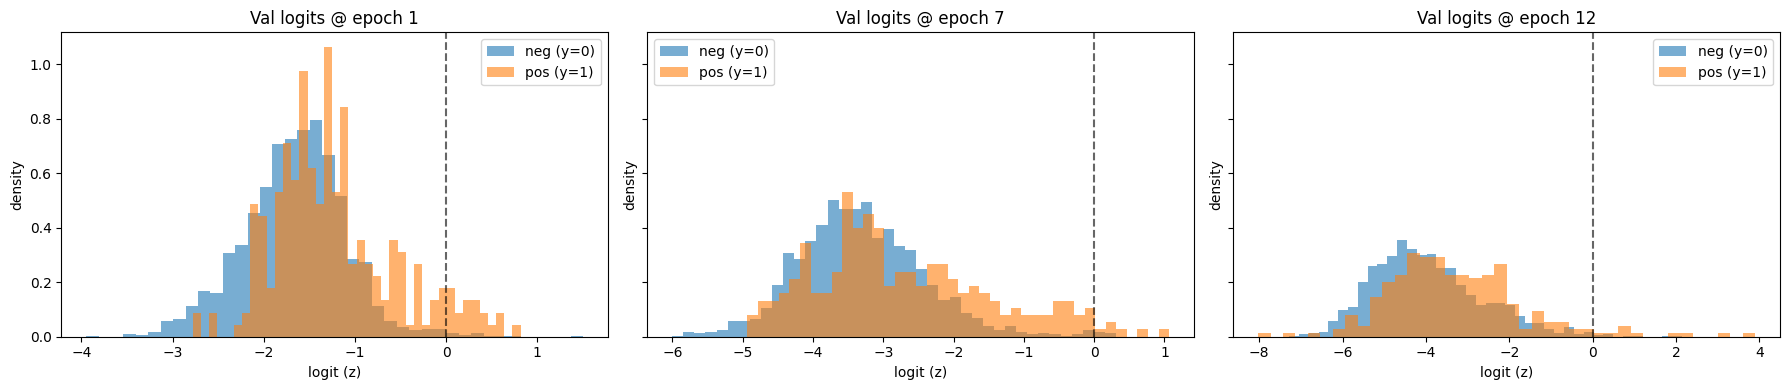

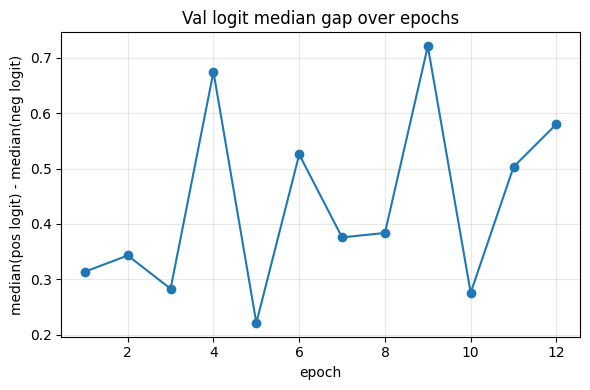

Train Loss,█▅▄▅▄▃▃▃▂▂▁▁
Val AUPR,▁█▇█▅▇▄▇▆▅▇▆▄
Val AUROC,▁█▇▇▆▂▅▅▄▅▂▅▅
Val Loss,█▁▁▁▁▁▁▁▁▂▂▂▂
val_logit_gap,▂▃▂▇▁▅▃▃█▂▅▆
val_neg_median_logit,█▅▆▇▇▃▃▄▂▂▁▂
val_pos_median_logit,█▅▅█▇▄▃▄▃▁▁▂
Train Loss,0.08197
Val AUPR,0.19101
Val AUROC,0.62561
Val Loss,0.42573


Training model 289a7027-81b5-4ea5-bdba-7ec07779d650
Before training - Val Loss 1.1206 | Val AUROC 0.6058 | Val AUPR 0.2369
EPOCH 1 - Train Loss 0.3215 | Val Loss 0.5832 | Val AUROC 0.4993 | Val AUPR 0.1685
EPOCH 2 - Train Loss 0.2358 | Val Loss 0.6327 | Val AUROC 0.5388 | Val AUPR 0.1864
EPOCH 3 - Train Loss 0.1984 | Val Loss 0.6639 | Val AUROC 0.4809 | Val AUPR 0.1850
EPOCH 4 - Train Loss 0.1588 | Val Loss 0.7202 | Val AUROC 0.5229 | Val AUPR 0.1833
EPOCH 5 - Train Loss 0.1192 | Val Loss 0.7857 | Val AUROC 0.4846 | Val AUPR 0.1747
EPOCH 6 - Train Loss 0.0973 | Val Loss 0.7841 | Val AUROC 0.4900 | Val AUPR 0.1758
EPOCH 7 - Train Loss 0.0847 | Val Loss 0.7925 | Val AUROC 0.4467 | Val AUPR 0.1642
EPOCH 8 - Train Loss 0.0522 | Val Loss 0.8210 | Val AUROC 0.4130 | Val AUPR 0.1607
EPOCH 9 - Train Loss 0.0462 | Val Loss 0.8646 | Val AUROC 0.4231 | Val AUPR 0.1597
EPOCH 10 - Train Loss 0.0240 | Val Loss 0.8761 | Val AUROC 0.4447 | Val AUPR 0.1654
EPOCH 11 - Train Loss 0.0249 | Val Loss 0.9230

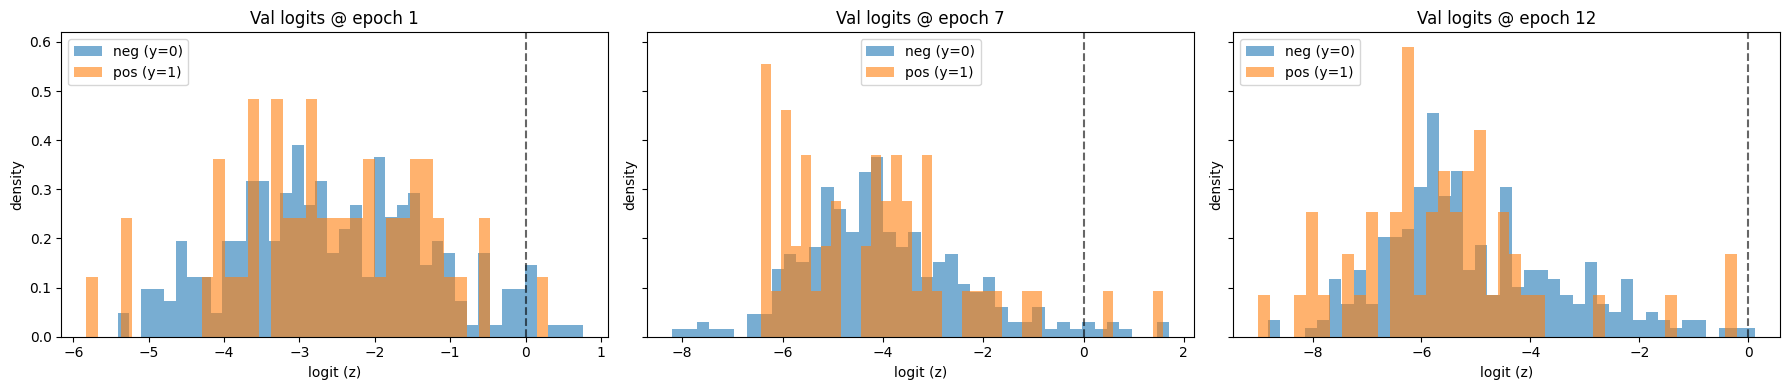

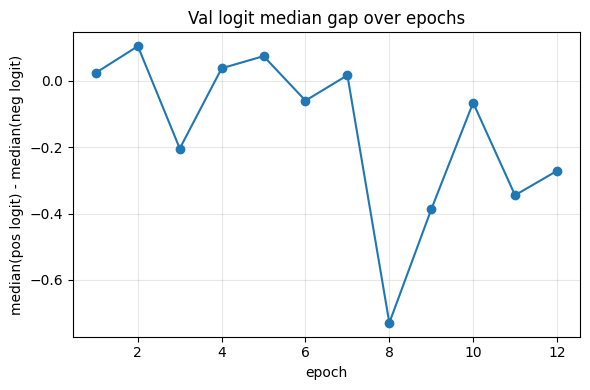

Train Loss,█▆▅▄▃▃▂▂▂▁▁▁
Val AUPR,█▂▄▄▃▃▃▂▂▂▂▃▁
Val AUROC,█▄▆▄▅▄▄▃▂▂▃▁▁
Val Loss,█▁▂▂▃▄▄▄▄▅▅▅▆
val_logit_gap,▇█▅▇█▇▇▁▄▇▄▅
val_neg_median_logit,█▆▅▅▄▄▄▄▃▂▂▁
val_pos_median_logit,█▆▅▅▄▄▅▂▂▃▂▁
Train Loss,0.03783
Val AUPR,0.15352
Val AUROC,0.40769
Val Loss,0.9747


Training model 289a7027-81b5-4ea5-bdba-7ec07779d650
Before training - Val Loss 0.7167 | Val AUROC 0.6781 | Val AUPR 0.1806
EPOCH 1 - Train Loss 0.3218 | Val Loss 0.3852 | Val AUROC 0.5536 | Val AUPR 0.1297
EPOCH 2 - Train Loss 0.2264 | Val Loss 0.6187 | Val AUROC 0.6124 | Val AUPR 0.1479
EPOCH 3 - Train Loss 0.2081 | Val Loss 0.4421 | Val AUROC 0.6128 | Val AUPR 0.1579
EPOCH 4 - Train Loss 0.1648 | Val Loss 0.4872 | Val AUROC 0.5590 | Val AUPR 0.1324
EPOCH 5 - Train Loss 0.1364 | Val Loss 0.5958 | Val AUROC 0.5250 | Val AUPR 0.1274
EPOCH 6 - Train Loss 0.1133 | Val Loss 0.5734 | Val AUROC 0.5786 | Val AUPR 0.1411
EPOCH 7 - Train Loss 0.0870 | Val Loss 0.4732 | Val AUROC 0.5693 | Val AUPR 0.1452
EPOCH 8 - Train Loss 0.0615 | Val Loss 0.5717 | Val AUROC 0.5821 | Val AUPR 0.1567
EPOCH 9 - Train Loss 0.0464 | Val Loss 0.5900 | Val AUROC 0.5217 | Val AUPR 0.1367
EPOCH 10 - Train Loss 0.0481 | Val Loss 0.5292 | Val AUROC 0.5452 | Val AUPR 0.1489
EPOCH 11 - Train Loss 0.0390 | Val Loss 0.6086

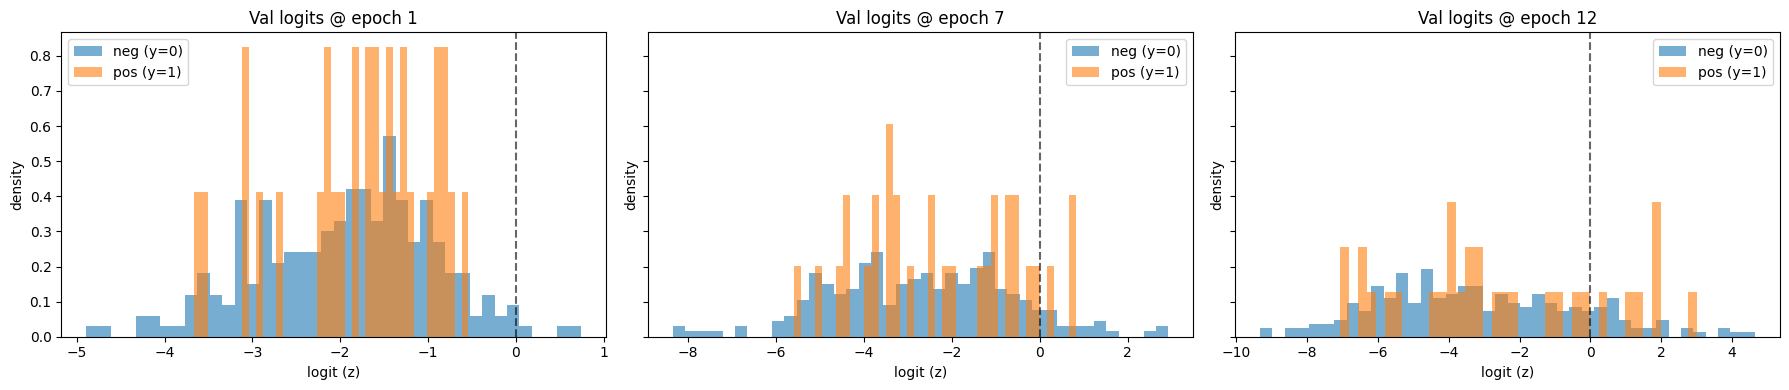

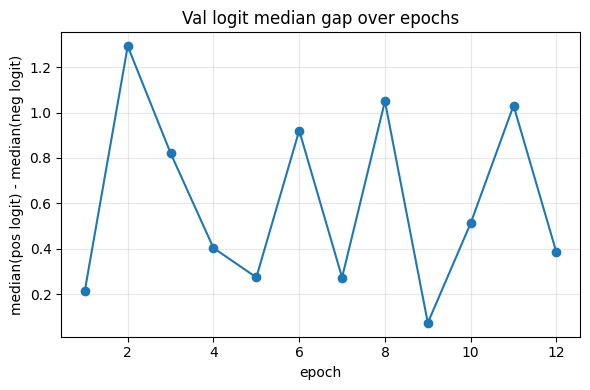

Train Loss,█▆▅▄▄▃▃▂▂▂▁▁
Val AUPR,█▁▄▅▂▁▃▃▅▂▄▆▄
Val AUROC,█▂▅▅▃▁▄▃▄▁▂▄▃
Val Loss,█▁▆▂▃▅▅▃▅▅▄▆▆
val_logit_gap,▂█▅▃▂▆▂▇▁▄▆▃
val_neg_median_logit,▆█▇▇▄▅▄▄▄▂▄▁
val_pos_median_logit,▄█▆▅▃▅▃▄▂▂▅▁
Train Loss,0.01952
Val AUPR,0.15376
Val AUROC,0.55645
Val Loss,0.6258


Training model 289a7027-81b5-4ea5-bdba-7ec07779d650
Before training - Val Loss 0.5645 | Val AUROC 0.5779 | Val AUPR 0.1244
EPOCH 1 - Train Loss 0.3154 | Val Loss 0.2944 | Val AUROC 0.5422 | Val AUPR 0.0870
EPOCH 2 - Train Loss 0.2518 | Val Loss 0.3201 | Val AUROC 0.5266 | Val AUPR 0.0779
EPOCH 3 - Train Loss 0.2220 | Val Loss 0.3075 | Val AUROC 0.5766 | Val AUPR 0.0933
EPOCH 4 - Train Loss 0.1771 | Val Loss 0.3824 | Val AUROC 0.5520 | Val AUPR 0.0829
EPOCH 5 - Train Loss 0.1346 | Val Loss 0.3566 | Val AUROC 0.5102 | Val AUPR 0.0820
EPOCH 6 - Train Loss 0.1008 | Val Loss 0.3769 | Val AUROC 0.5344 | Val AUPR 0.0870
EPOCH 7 - Train Loss 0.0814 | Val Loss 0.3493 | Val AUROC 0.5420 | Val AUPR 0.0841
EPOCH 8 - Train Loss 0.0553 | Val Loss 0.3693 | Val AUROC 0.5345 | Val AUPR 0.0787
EPOCH 9 - Train Loss 0.0638 | Val Loss 0.3756 | Val AUROC 0.5477 | Val AUPR 0.0889
EPOCH 10 - Train Loss 0.0429 | Val Loss 0.3831 | Val AUROC 0.5256 | Val AUPR 0.0818
EPOCH 11 - Train Loss 0.0380 | Val Loss 0.3474

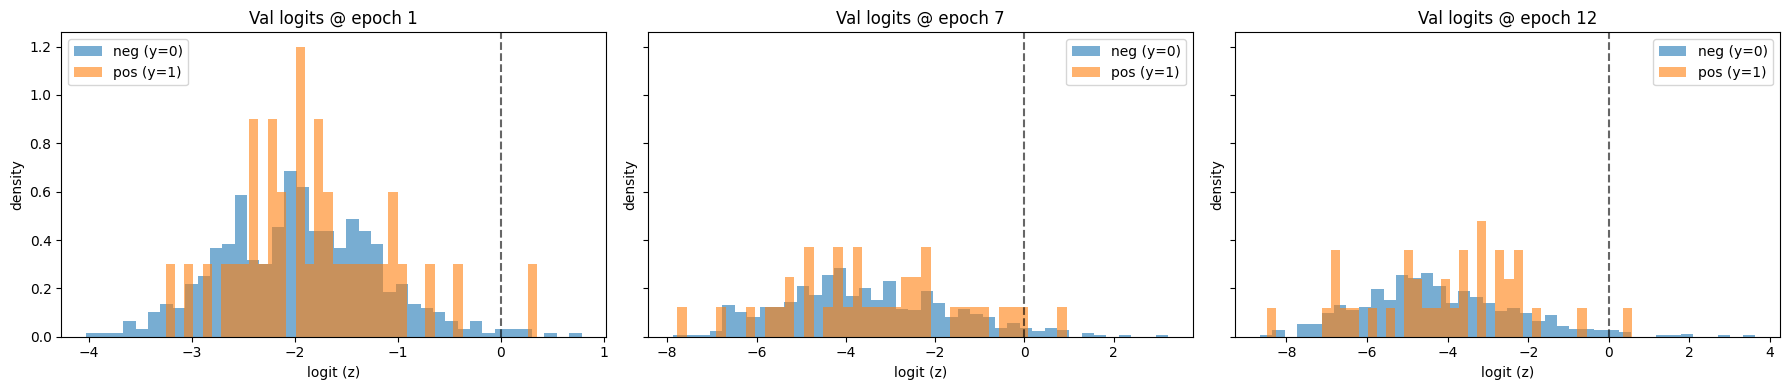

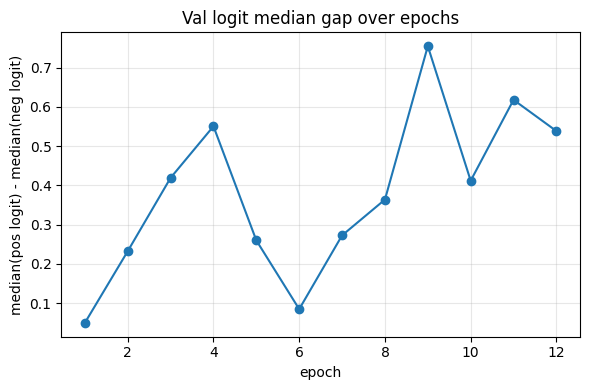

Train Loss,█▆▆▅▄▃▂▂▂▁▁▁
Val AUPR,█▂▁▃▂▂▂▂▁▃▂▂▂
Val AUROC,█▄▃█▅▁▄▄▄▅▃▆▅
Val Loss,█▁▂▁▃▃▃▂▃▃▃▂▃
val_logit_gap,▁▃▅▆▃▁▃▄█▅▇▆
val_neg_median_logit,█▄▇▆▃▅▃▁▃▁▃▂
val_pos_median_logit,█▃█▇▃▄▃▁▄▁▄▂
Train Loss,0.02901
Val AUPR,0.08176
Val AUROC,0.54425
Val Loss,0.36137


Training model 289a7027-81b5-4ea5-bdba-7ec07779d650
Before training - Val Loss 0.8068 | Val AUROC 0.5047 | Val AUPR 0.1241
EPOCH 1 - Train Loss 0.3166 | Val Loss 0.3864 | Val AUROC 0.4534 | Val AUPR 0.1065
EPOCH 2 - Train Loss 0.2170 | Val Loss 0.4006 | Val AUROC 0.5241 | Val AUPR 0.1490
EPOCH 3 - Train Loss 0.1851 | Val Loss 0.4012 | Val AUROC 0.5062 | Val AUPR 0.1660
EPOCH 4 - Train Loss 0.1605 | Val Loss 0.3696 | Val AUROC 0.5369 | Val AUPR 0.2289
EPOCH 5 - Train Loss 0.1429 | Val Loss 0.3634 | Val AUROC 0.5369 | Val AUPR 0.1811
EPOCH 6 - Train Loss 0.1039 | Val Loss 0.4828 | Val AUROC 0.5221 | Val AUPR 0.2069
EPOCH 7 - Train Loss 0.0912 | Val Loss 0.4321 | Val AUROC 0.5233 | Val AUPR 0.1647
EPOCH 8 - Train Loss 0.0728 | Val Loss 0.4698 | Val AUROC 0.5493 | Val AUPR 0.1545
EPOCH 9 - Train Loss 0.0740 | Val Loss 0.4698 | Val AUROC 0.5152 | Val AUPR 0.2028
EPOCH 10 - Train Loss 0.0656 | Val Loss 0.5020 | Val AUROC 0.5490 | Val AUPR 0.2384
EPOCH 11 - Train Loss 0.0463 | Val Loss 0.4830

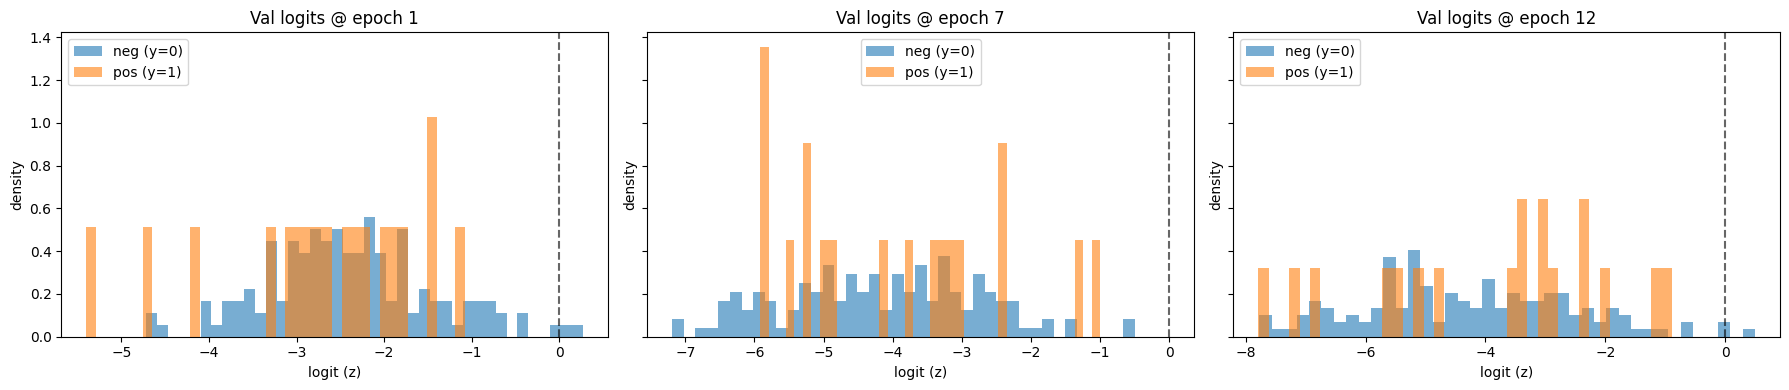

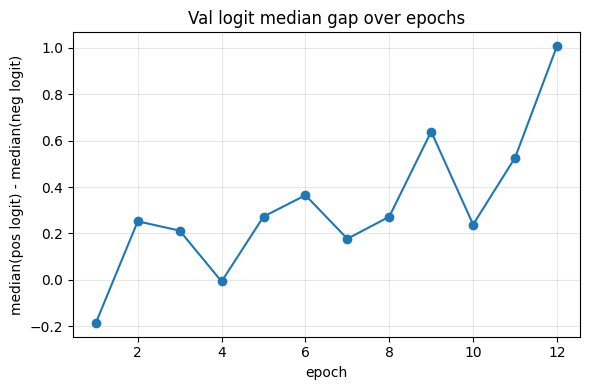

Train Loss,█▆▅▄▄▃▂▂▂▂▁▁
Val AUPR,▂▁▃▄▇▅▆▄▄▆█▆▄
Val AUROC,▄▁▅▄▆▆▅▅▇▅▇▆█
Val Loss,█▁▂▂▁▁▃▂▃▃▃▃▂
val_logit_gap,▁▄▃▂▄▄▃▄▆▃▅█
val_neg_median_logit,▇█▅▇▇▂▄▃▆▁▂▃
val_pos_median_logit,▆█▅▆▇▂▄▃▇▁▃▅
Train Loss,0.03321
Val AUPR,0.15491
Val AUROC,0.56954
Val Loss,0.44339


In [25]:
batch_size = 20
learning_rate = 2e-5
EPOCHS = 12
g = torch.Generator().manual_seed(SEED)

# login once (env var preferred)
if use_wandb:
    import wandb
    wandb.login()

class PairListDataset(Dataset):
    def __init__(self, examples, weights=None):
        self.examples = examples
        self.weights = weights  # optional per-sample weights (list/array)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        b = torch.as_tensor(b, dtype=torch.float32)
        t = torch.as_tensor(t, dtype=torch.float32)
        y = torch.tensor(float(y), dtype=torch.float32)
        if self.weights is None:
            return b, t, y
        else:
            w = torch.tensor(float(self.weights[idx]), dtype=torch.float32)
            return b, t, y, w

ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
# model.train()

for i in range(len(cv_splits)):
    # NEW model per split
    model = MiniCLIP_w_transformer_crossattn()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # validation
    val_targets = cv_splits[i][0]
    val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
    val_binders = [ALL_btl[idx] for idx in val_idx]
    val_binders = PairListDataset(val_binders)

    # training
    train_targets = cv_splits[i][1]

    train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
    train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
    train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
    train_weights_combined_boost_positives = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_boost_pos"].tolist()

    train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
    train_binders = [ALL_btl[idx] for idx in train_idx]
    train_binders = PairListDataset(train_binders)

    # loaders
    ### no weighting
    # train_loader   = DataLoader(train_binders, batch_size=20, shuffle=True)

    ### class weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### target weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_target, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting (boost positives)
    train_sampler = WeightedRandomSampler(weights=train_weights_target, num_samples=train_binders.__len__(), replacement=True, generator = g)
    train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)
    
    val_loader   = DataLoader(val_binders,   batch_size=20, shuffle=False, drop_last = False)

    # accelerator
    accelerator = Accelerator()
    device = accelerator.device
    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    # wandb
    if use_wandb:
        run = wandb.init(
            project="CLIP_PPint_metaanalysis_weighting",
            name=f"split{i+1}_target_weight",
            group="cv_splits",
            config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
                    "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
        )
        wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
    else:
        run = None

    # train
    training_wrapper = TrainWrapper_MetaAnal(
        model=model,
        training_loader=train_loader,
        validation_loader=val_loader,
        test_dataset=val_binders,   # ok if you truly want “full val”
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        runID=runID,
        device=device,
        model_save_steps=model_save_steps,
        model_save_path=trained_model_dir,
        v=True,
        wandb_tracker=run,
        split_id=i+1
    )
    training_wrapper.train_model()

    # cleanup between splits
    if use_wandb:
        wandb.finish()
    del training_wrapper, model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    try:
        accelerator.free_memory()
    except AttributeError:
        pass

## target+class weighting (12 epochs)

Training model bb63d27b-08d7-48c1-b3c6-60217d530374
Before training - Val Loss 1.1936 | Val AUROC 0.5581 | Val AUPR 0.1265
EPOCH 1 - Train Loss 0.5083 | Val Loss 0.7603 | Val AUROC 0.6520 | Val AUPR 0.1993
EPOCH 2 - Train Loss 0.3756 | Val Loss 0.5055 | Val AUROC 0.5912 | Val AUPR 0.2147
EPOCH 3 - Train Loss 0.3357 | Val Loss 0.4240 | Val AUROC 0.5739 | Val AUPR 0.2186
EPOCH 4 - Train Loss 0.2861 | Val Loss 0.5977 | Val AUROC 0.6144 | Val AUPR 0.1618
EPOCH 5 - Train Loss 0.2160 | Val Loss 0.3770 | Val AUROC 0.5905 | Val AUPR 0.1876
EPOCH 6 - Train Loss 0.2053 | Val Loss 0.4182 | Val AUROC 0.6201 | Val AUPR 0.1973
EPOCH 7 - Train Loss 0.1694 | Val Loss 0.3936 | Val AUROC 0.6053 | Val AUPR 0.1981
EPOCH 8 - Train Loss 0.1281 | Val Loss 0.3883 | Val AUROC 0.5565 | Val AUPR 0.1865
EPOCH 9 - Train Loss 0.0977 | Val Loss 0.4776 | Val AUROC 0.5604 | Val AUPR 0.1640
EPOCH 10 - Train Loss 0.0814 | Val Loss 0.4233 | Val AUROC 0.5582 | Val AUPR 0.2016
EPOCH 11 - Train Loss 0.0411 | Val Loss 0.4233

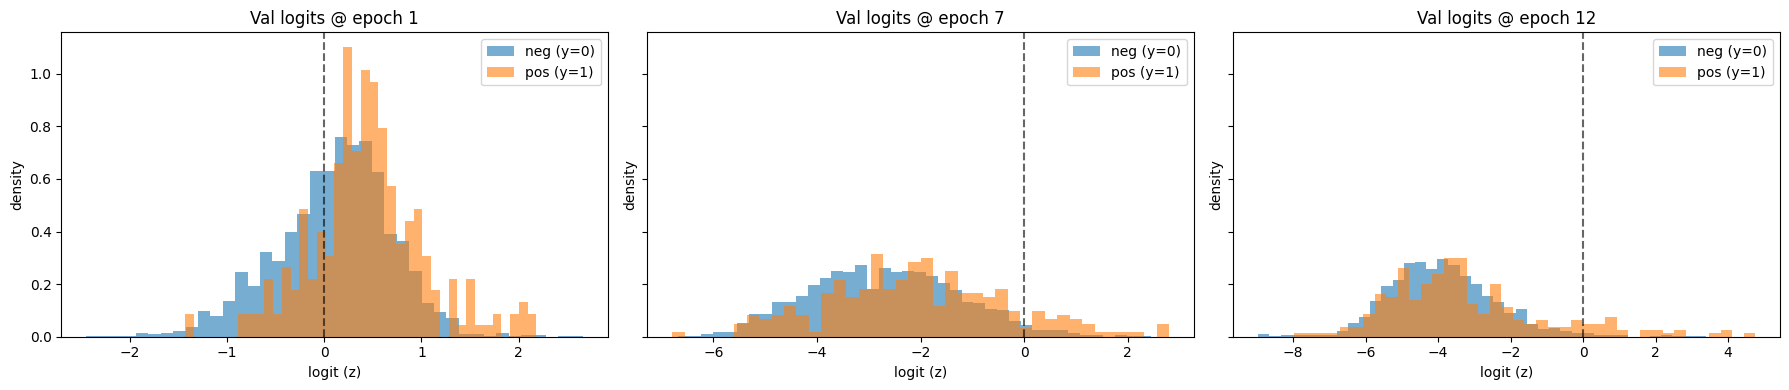

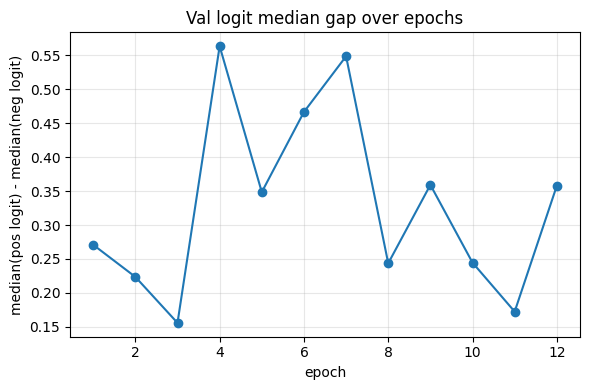

Training model bb63d27b-08d7-48c1-b3c6-60217d530374
Before training - Val Loss 1.1206 | Val AUROC 0.6058 | Val AUPR 0.2369
EPOCH 1 - Train Loss 0.5379 | Val Loss 0.5576 | Val AUROC 0.6017 | Val AUPR 0.2144
EPOCH 2 - Train Loss 0.4253 | Val Loss 0.5921 | Val AUROC 0.5824 | Val AUPR 0.1985
EPOCH 3 - Train Loss 0.3605 | Val Loss 0.5841 | Val AUROC 0.5889 | Val AUPR 0.2199
EPOCH 4 - Train Loss 0.3284 | Val Loss 0.6893 | Val AUROC 0.5064 | Val AUPR 0.1825
EPOCH 5 - Train Loss 0.2647 | Val Loss 0.6627 | Val AUROC 0.5607 | Val AUPR 0.2006
EPOCH 6 - Train Loss 0.2093 | Val Loss 0.6881 | Val AUROC 0.4920 | Val AUPR 0.1796
EPOCH 7 - Train Loss 0.1736 | Val Loss 0.7683 | Val AUROC 0.4555 | Val AUPR 0.1983
EPOCH 8 - Train Loss 0.1358 | Val Loss 0.7578 | Val AUROC 0.4864 | Val AUPR 0.1910
EPOCH 9 - Train Loss 0.0902 | Val Loss 0.7704 | Val AUROC 0.4361 | Val AUPR 0.1526
EPOCH 10 - Train Loss 0.0610 | Val Loss 0.7814 | Val AUROC 0.5013 | Val AUPR 0.1705
EPOCH 11 - Train Loss 0.0603 | Val Loss 0.8209

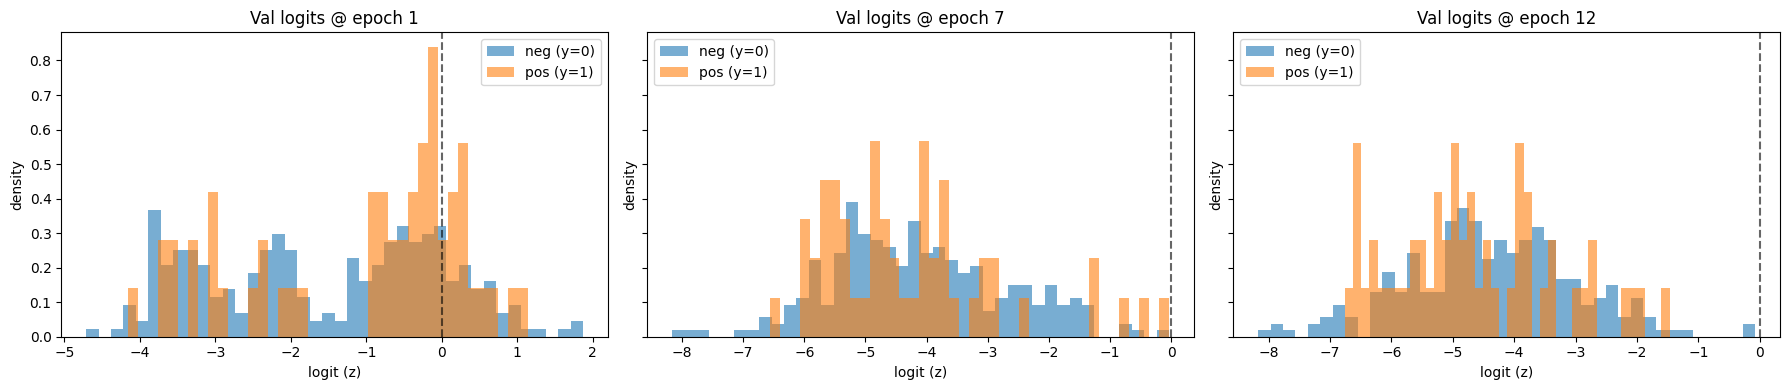

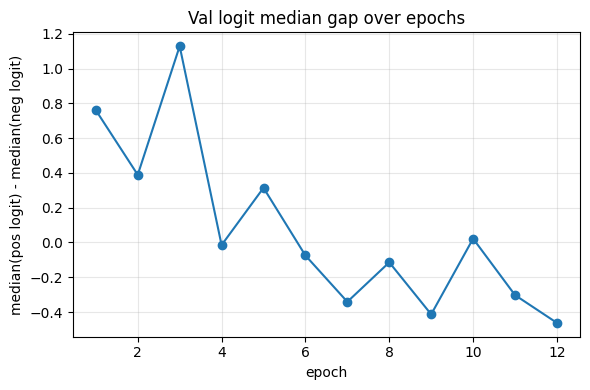

Training model bb63d27b-08d7-48c1-b3c6-60217d530374
Before training - Val Loss 0.7167 | Val AUROC 0.6781 | Val AUPR 0.1806
EPOCH 1 - Train Loss 0.5257 | Val Loss 0.7772 | Val AUROC 0.5526 | Val AUPR 0.1269
EPOCH 2 - Train Loss 0.4247 | Val Loss 0.8367 | Val AUROC 0.6181 | Val AUPR 0.1594
EPOCH 3 - Train Loss 0.3786 | Val Loss 0.7480 | Val AUROC 0.6575 | Val AUPR 0.1630
EPOCH 4 - Train Loss 0.3175 | Val Loss 0.4584 | Val AUROC 0.5984 | Val AUPR 0.1503
EPOCH 5 - Train Loss 0.2784 | Val Loss 0.5705 | Val AUROC 0.6214 | Val AUPR 0.1789
EPOCH 6 - Train Loss 0.2459 | Val Loss 0.6477 | Val AUROC 0.6236 | Val AUPR 0.1671
EPOCH 7 - Train Loss 0.1710 | Val Loss 0.7700 | Val AUROC 0.6390 | Val AUPR 0.1824
EPOCH 8 - Train Loss 0.1405 | Val Loss 0.5580 | Val AUROC 0.5938 | Val AUPR 0.1830
EPOCH 9 - Train Loss 0.0966 | Val Loss 0.7336 | Val AUROC 0.6148 | Val AUPR 0.1789
EPOCH 10 - Train Loss 0.0854 | Val Loss 0.8258 | Val AUROC 0.6048 | Val AUPR 0.1611
EPOCH 11 - Train Loss 0.0573 | Val Loss 0.6124

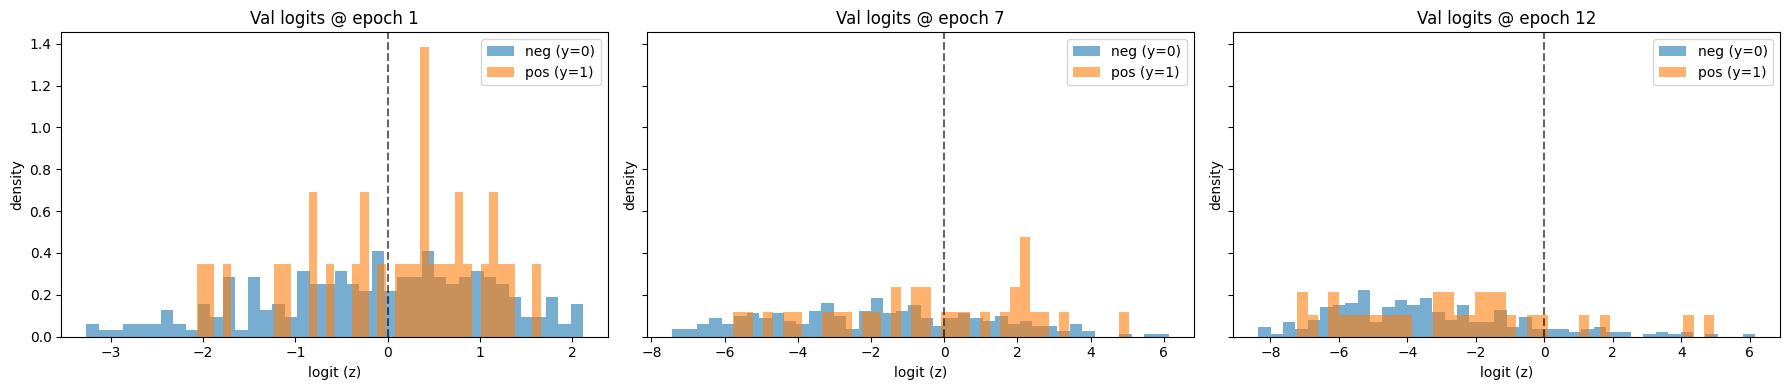

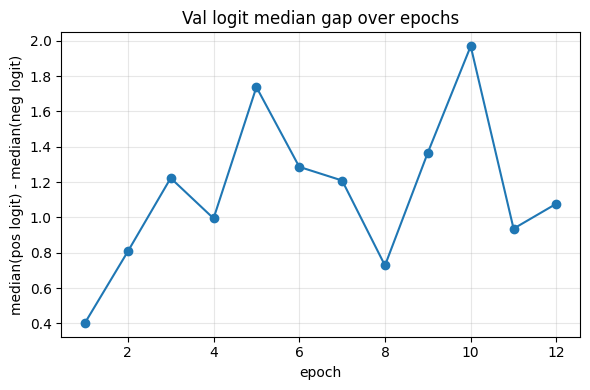

Training model bb63d27b-08d7-48c1-b3c6-60217d530374
Before training - Val Loss 0.5645 | Val AUROC 0.5779 | Val AUPR 0.1244
EPOCH 1 - Train Loss 0.5216 | Val Loss 0.4194 | Val AUROC 0.6414 | Val AUPR 0.0926
EPOCH 2 - Train Loss 0.4606 | Val Loss 0.4171 | Val AUROC 0.5431 | Val AUPR 0.0753
EPOCH 3 - Train Loss 0.3596 | Val Loss 0.4513 | Val AUROC 0.5409 | Val AUPR 0.0755
EPOCH 4 - Train Loss 0.3097 | Val Loss 0.5595 | Val AUROC 0.5538 | Val AUPR 0.0790
EPOCH 5 - Train Loss 0.2853 | Val Loss 0.4137 | Val AUROC 0.4891 | Val AUPR 0.0685
EPOCH 6 - Train Loss 0.2211 | Val Loss 0.4239 | Val AUROC 0.4805 | Val AUPR 0.0708
EPOCH 7 - Train Loss 0.1780 | Val Loss 0.5345 | Val AUROC 0.4401 | Val AUPR 0.0676
EPOCH 8 - Train Loss 0.1209 | Val Loss 0.4297 | Val AUROC 0.4850 | Val AUPR 0.0687
EPOCH 9 - Train Loss 0.1079 | Val Loss 0.4980 | Val AUROC 0.4571 | Val AUPR 0.0644
EPOCH 10 - Train Loss 0.0866 | Val Loss 0.4269 | Val AUROC 0.4488 | Val AUPR 0.0690
EPOCH 11 - Train Loss 0.0661 | Val Loss 0.4427

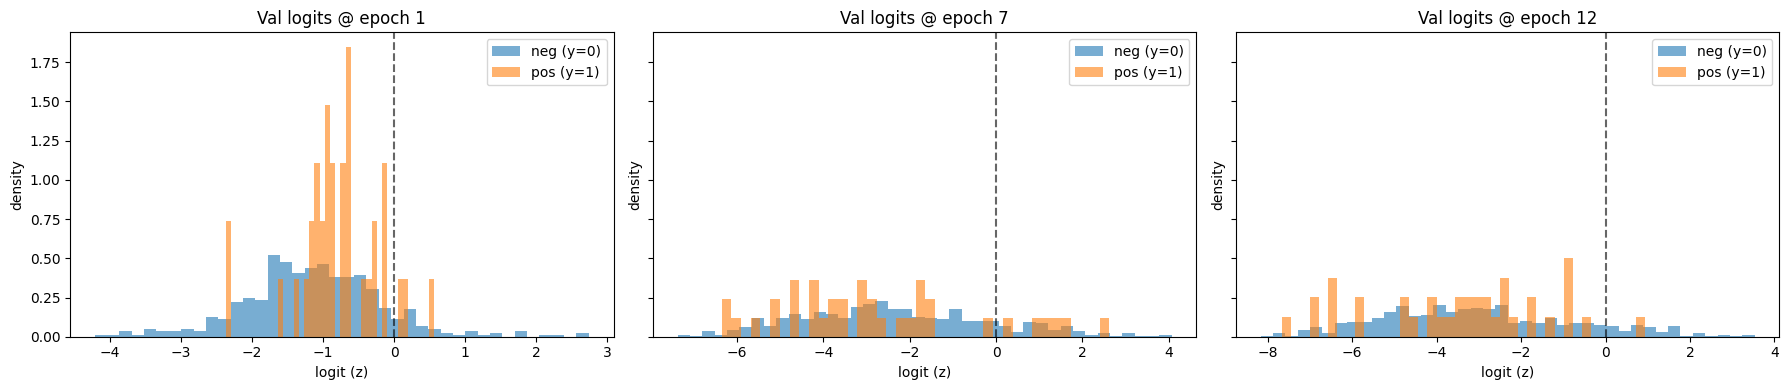

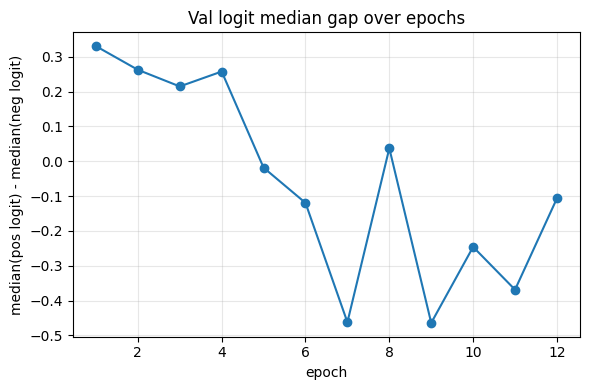

Training model bb63d27b-08d7-48c1-b3c6-60217d530374
Before training - Val Loss 0.8068 | Val AUROC 0.5047 | Val AUPR 0.1241
EPOCH 1 - Train Loss 0.5446 | Val Loss 0.5231 | Val AUROC 0.4161 | Val AUPR 0.1097
EPOCH 2 - Train Loss 0.4261 | Val Loss 0.3797 | Val AUROC 0.4961 | Val AUPR 0.1815
EPOCH 3 - Train Loss 0.3719 | Val Loss 0.3902 | Val AUROC 0.5214 | Val AUPR 0.1235
EPOCH 4 - Train Loss 0.3096 | Val Loss 0.4554 | Val AUROC 0.5109 | Val AUPR 0.1396
EPOCH 5 - Train Loss 0.2653 | Val Loss 0.4878 | Val AUROC 0.5287 | Val AUPR 0.1402
EPOCH 6 - Train Loss 0.2131 | Val Loss 0.4629 | Val AUROC 0.5194 | Val AUPR 0.1687
EPOCH 7 - Train Loss 0.1606 | Val Loss 0.4776 | Val AUROC 0.5474 | Val AUPR 0.1488
EPOCH 8 - Train Loss 0.1293 | Val Loss 0.5607 | Val AUROC 0.4705 | Val AUPR 0.1195
EPOCH 9 - Train Loss 0.0823 | Val Loss 0.5901 | Val AUROC 0.4868 | Val AUPR 0.1185
EPOCH 10 - Train Loss 0.0618 | Val Loss 0.5545 | Val AUROC 0.4775 | Val AUPR 0.1084
EPOCH 11 - Train Loss 0.0636 | Val Loss 0.5772

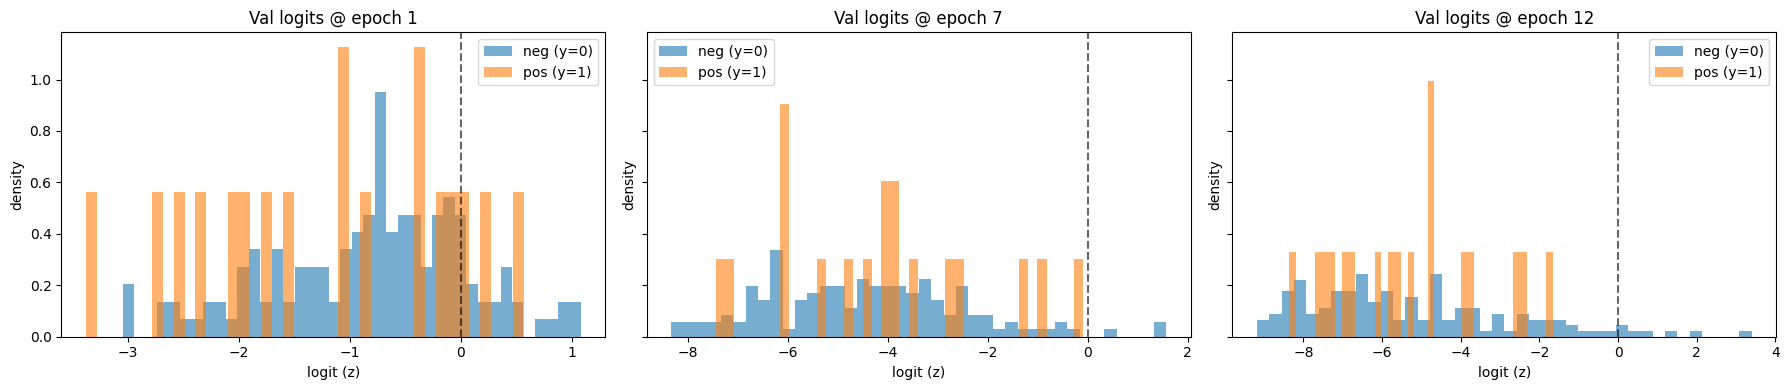

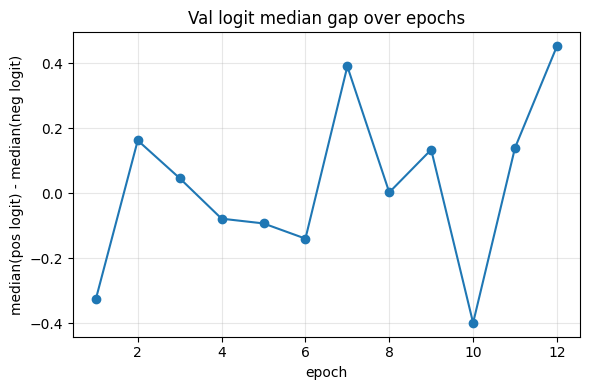

In [26]:
batch_size = 20
learning_rate = 2e-5
EPOCHS = 12
g = torch.Generator().manual_seed(SEED)

# login once (env var preferred)
if use_wandb:
    import wandb
    wandb.login()

class PairListDataset(Dataset):
    def __init__(self, examples, weights=None):
        self.examples = examples
        self.weights = weights  # optional per-sample weights (list/array)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        b = torch.as_tensor(b, dtype=torch.float32)
        t = torch.as_tensor(t, dtype=torch.float32)
        y = torch.tensor(float(y), dtype=torch.float32)
        if self.weights is None:
            return b, t, y
        else:
            w = torch.tensor(float(self.weights[idx]), dtype=torch.float32)
            return b, t, y, w

ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
# model.train()

for i in range(len(cv_splits)):
    # NEW model per split
    model = MiniCLIP_w_transformer_crossattn()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # validation
    val_targets = cv_splits[i][0]
    val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
    val_binders = [ALL_btl[idx] for idx in val_idx]
    val_binders = PairListDataset(val_binders)

    # training
    train_targets = cv_splits[i][1]

    train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
    train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
    train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
    train_weights_combined_boost_positives = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_boost_pos"].tolist()

    train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
    train_binders = [ALL_btl[idx] for idx in train_idx]
    train_binders = PairListDataset(train_binders)

    # loaders
    ### no weighting
    # train_loader   = DataLoader(train_binders, batch_size=20, shuffle=True)

    ### class weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### target weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_target, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting (boost positives)
    train_sampler = WeightedRandomSampler(weights=train_weights_combined, num_samples=train_binders.__len__(), replacement=True, generator = g)
    train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)
    
    val_loader   = DataLoader(val_binders,   batch_size=20, shuffle=False, drop_last = False)

    # accelerator
    accelerator = Accelerator()
    device = accelerator.device
    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    # wandb
    # if use_wandb:
    #     run = wandb.init(
    #         project="FT_on_meta_weighting",
    #         name=f"split{i+1}_class&target_weight",
    #         group="cv_splits",
    #         config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
    #                 "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
    #     )
    #     wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
    # else:
    #     run = None

    # train
    training_wrapper = TrainWrapper_MetaAnal(
        model=model,
        training_loader=train_loader,
        validation_loader=val_loader,
        test_dataset=val_binders,   # ok if you truly want “full val”
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        runID=runID,
        device=device,
        model_save_steps=model_save_steps,
        model_save_path=trained_model_dir,
        v=True,
        wandb_tracker=False,
        split_id=i+1
    )
    training_wrapper.train_model()

    # cleanup between splits
    if use_wandb:
        wandb.finish()
    del training_wrapper, model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    try:
        accelerator.free_memory()
    except AttributeError:
        pass

## pos_weight in binary loss calculation

In [25]:
def batch(iterable, n=20):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

all_hist = []

class TrainWrapper_MetaAnal():

    def __init__(self, model, training_loader, validation_loader, test_dataset, 
                 optimizer, EPOCHS, runID, pos_weight, device, test_indexes_for_auROC=None,
                 auROC_batch_size=18, model_save_steps=False, model_save_path=False, 
                 v=False, wandb_tracker=False, split_id=None):
        
        self.model = model 
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.EPOCHS = EPOCHS
        self.wandb_tracker = wandb_tracker
        self.model_save_steps = model_save_steps
        self.verbose = v
        self.split_id = split_id
        self.best_vloss = 1e09
        self.optimizer = optimizer
        self.pos_weight = pos_weight
        self.runID = runID
        self.trained_model_dir = model_save_path
        self.print_frequency_loss = 1
        self.device = device
        self.test_indexes_for_auROC = test_indexes_for_auROC
        self.auROC_batch_size = auROC_batch_size
        self.test_dataset = test_dataset

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0
        # for batch_data in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):
        for batch_data in self.training_loader:
            if batch_data[0].size(0) == 1:
                continue
            self.optimizer.zero_grad()
            loss = self.model.training_step(batch_data, self.pos_weight, self.device)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()

        return running_loss / max(1, len(self.training_loader))

    def calc_auroc_aupr_on_indexes(self, model, validation_dataset, batch_size=20, pad_value=-5000.0):
        
        model.eval()
        all_scores, all_labels = [], []
        batched_data = batch(validation_dataset, n=batch_size)
        
        with torch.no_grad():
            # for one_batch in tqdm(batched_data, total= len(validation_dataset)/batch_size, desc="Calculating AUC"):
            for one_batch in batched_data:
                
                embedding_pep, embedding_prot, binder_labels = batch
                embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()
                
                logits = model.forward(binders, targets)
                
                all_scores.extend(logits.tolist())
                all_labels.extend(binder_labels.tolist())
                
        all_scores = np.array(all_scores, dtype=np.float64)
        all_labels = np.array(all_labels, dtype=np.int64)
        
        fpr, tpr, _ = metrics.roc_curve(all_labels, all_scores)
        auroc = metrics.roc_auc_score(all_labels, all_scores)
        aupr  = metrics.average_precision_score(all_labels, all_scores)
        
        return auroc, aupr, fpr, tpr

    def validate(self, dataloader, indexes_for_auc=False, auROC_dataset=False):
        
        self.model.eval()
        running_loss, n_loss = 0.0, 0
        all_scores, all_labels = [], []
        
        with torch.no_grad():
            # for batch_data in tqdm(dataloader, total=len(dataloader), desc="Validation"):
            for batch_data in dataloader:
                
                loss, logits, labels = self.model.validation_step(batch_data, self.device)
                
                running_loss += float(loss)
                n_loss += 1
                all_scores.append(logits.detach().float().cpu())
                all_labels.append(labels.detach().long().cpu())
    
        val_loss = running_loss / max(1, n_loss)
    
        if all_scores:
            scores = torch.cat(all_scores).numpy()
            labs   = torch.cat(all_labels).numpy()
            val_auroc = metrics.roc_auc_score(labs, scores)
            val_aupr  = metrics.average_precision_score(labs, scores)
        else:
            scores = np.array([], dtype=np.float64)   # <-- define when empty
            labs   = np.array([], dtype=np.int64)
            val_auroc = float("nan")
            val_aupr  = float("nan")
    
        return val_loss, val_auroc, val_aupr, scores, labs

    def _plot_val_histories(self, hist, epochs_to_show=("first","middle","last")):
    
        if not hist:
            return
    
        epochs = [e for (e,_,_) in hist]
        choose = []
        if "first" in epochs_to_show:
            choose.append(epochs[0])
        if "middle" in epochs_to_show:
            choose.append(epochs[len(epochs)//2])
        if "last" in epochs_to_show:
            choose.append(epochs[-1])
        choose = sorted(set(choose))
    
        # grid of histograms
        ncols = len(choose)
        fig, axs = plt.subplots(1, ncols, figsize=(6*ncols, 4), sharey=True)
        if ncols == 1: axs = [axs]
    
        for ax, ek in zip(axs, choose):
            # fetch data for epoch ek
            for (e, s, y) in hist:
                if e == ek:
                    scores, labs = s, y
                    break
            pos = scores[labs == 1]
            neg = scores[labs == 0]
    
            ax.hist(neg, bins=40, density=True, alpha=0.6, label="neg (y=0)")
            ax.hist(pos, bins=40, density=True, alpha=0.6, label="pos (y=1)")
            ax.axvline(0.0, ls="--", color="k", alpha=0.6)  # decision boundary (logit 0)
            ax.set_title(f"Val logits @ epoch {ek}")
            ax.set_xlabel("logit (z)"); ax.set_ylabel("density")
            ax.legend()
    
        plt.tight_layout(); plt.show()
    
        # median gap curve
        ep, gaps = [], []
        for e, s, y in hist:
            pos = s[y==1]; neg = s[y==0]
            if pos.size and neg.size:
                gaps.append(np.median(pos) - np.median(neg))
            else:
                gaps.append(np.nan)
            ep.append(e)
    
        plt.figure(figsize=(6,4))
        plt.plot(ep, gaps, marker="o")
        plt.xlabel("epoch"); plt.ylabel("median(pos logit) - median(neg logit)")
        plt.title("Val logit median gap over epochs")
        plt.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

    def train_model(self):

        if self.verbose:
            print(f"Training model {str(self.runID)}")
        
        # Pre-training snapshot
        val_loss, val_auroc, val_aupr, scores, labs = self.validate(dataloader=self.validation_loader, indexes_for_auc=self.test_indexes_for_auROC, auROC_dataset=self.test_dataset)

        if self.verbose:
            print(
                f'Before training - Val Loss {val_loss:.4f} | '
                f'Val AUROC {val_auroc if val_auroc==val_auroc else float("nan"):.4f} | '
                f'Val AUPR {val_aupr if val_aupr==val_aupr else float("nan"):.4f}'
            )

        if self.wandb_tracker:
            log_items = {
                "Val Loss": val_loss,
                "Val AUROC": val_auroc,
                "Val AUPR": val_aupr,
            }
            self.wandb_tracker.log(log_items)

        hist = []
        
        # --- Epoch loop ---
        # for epoch in tqdm(range(1, self.EPOCHS + 1), total=self.EPOCHS, desc="Epochs"):
        for epoch in range(1, self.EPOCHS + 1):
            
            torch.cuda.empty_cache()
            
            train_loss = self.train_one_epoch()
            val_loss, val_auroc, val_aupr, scores, labs  = self.validate(dataloader=self.validation_loader, indexes_for_auc=self.test_indexes_for_auROC, auROC_dataset=self.test_dataset)
            hist.append((epoch, scores, labs))
    
            if self.verbose and (epoch % self.print_frequency_loss == 0):
                print(
                    f'EPOCH {epoch} - Train Loss {train_loss:.4f} | '
                    f'Val Loss {val_loss:.4f} | Val AUROC {val_auroc if val_auroc==val_auroc else float("nan"):.4f} | '
                    f'Val AUPR {val_aupr if val_aupr==val_aupr else float("nan"):.4f}'
                )
    
            if scores.size and labs.size:
                pos_mask = labs == 1
                neg_mask = labs == 0
                median_pos = float(np.median(scores[pos_mask])) if pos_mask.any() else float("nan")
                median_neg = float(np.median(scores[neg_mask])) if neg_mask.any() else float("nan")
                gap = median_pos - median_neg if np.isfinite(median_pos) and np.isfinite(median_neg) else float("nan")
            else:
                pos_med = neg_med = gap = float("nan")
        
            if self.wandb_tracker:
                log_items = {
                    "Train Loss": train_loss,
                    "Val Loss": val_loss,
                    "Val AUROC": val_auroc,
                    "Val AUPR": val_aupr,
                    "val_pos_median_logit": median_pos,
                    "val_neg_median_logit": median_neg,
                    "val_logit_gap": gap,
                }
                # remove Nones so W&B doesn't complain
                log_items = {k: v for k, v in log_items.items() if v is not None}
                self.wandb_tracker.log(log_items, step=epoch)
        
        # after training, you can plot locally:
        all_hist.append(hist)
        self._plot_val_histories(hist)
    
        if self.wandb_tracker:
            self.wandb_tracker.finish()

In [26]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=1152, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value # -5000
        self.embed_dimension = embed_dimension #ESM-C 1152

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init
        # self.logit_bias = nn.Parameter(torch.tensor(0.0))

        # This step lets residues within the protein (and within the peptide) exchange information and form context-aware token embeddings.
        # Consider stacking encoder layers: nn.TransformerEncoder(encoder_layer, num_layers=N) for deeper context.
        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input, padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input, padding_value=self.padding_value)
 
        # Initialize residual states
        pep_emb = pep_input.clone()
        prot_emb = prot_input.clone()
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            pep_emb = pep_emb + pep_cross  
            prot_emb = prot_emb + prot_cross

            # keep self-attn residuals AND cross-attn residuals
            # pep_emb  = self.norm(prot_emb  + pep_trans  + pep_cross)
            # prot_emb = self.norm(prot_emb + prot_trans + prot_cross)

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding))
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding))
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(min=1.0, max=100.0)
        # logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1)
        # logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1) #+ self.logit_bias
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1) #+ self.logit_bias
        return logits

    def training_step(self, batch, pos_weight=None, device=device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        logits = self.forward(embedding_pep, embedding_prot)
        # print(logits)
        # print(binder_labels)
        
        # compute on TRAIN fold
        if pos_weight is not None:
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels, pos_weight=pos_weight)
        else:
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
        # print(loss)
        return loss
    
    def validation_step(self, batch, device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        with torch.no_grad():
            logits = self.forward(embedding_pep, embedding_prot)
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
    
        return float(loss), logits, binder_labels

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MiniCLIP_w_transformer_crossattn()
model.to(device)
# model.train()

MiniCLIP_w_transformer_crossattn(
  (transformerencoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
    )
    (linear1): Linear(in_features=1152, out_features=1152, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1152, out_features=1152, bias=True)
    (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
  )
  (prot_embedder): Sequential(
    (0): Linear(in_features=1152, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=32

Training model 8ee9b35b-61e8-467f-9025-94ed4e3b8d9a
Before training - Val Loss 1.1936 | Val AUROC 0.5581 | Val AUPR 0.1265
EPOCH 1 - Train Loss 1.3480 | Val Loss 0.8235 | Val AUROC 0.6258 | Val AUPR 0.2526
EPOCH 2 - Train Loss 1.1243 | Val Loss 0.7888 | Val AUROC 0.6397 | Val AUPR 0.2577
EPOCH 3 - Train Loss 1.0901 | Val Loss 0.5312 | Val AUROC 0.6707 | Val AUPR 0.2700
EPOCH 4 - Train Loss 0.9810 | Val Loss 0.5578 | Val AUROC 0.6422 | Val AUPR 0.2121
EPOCH 5 - Train Loss 0.9472 | Val Loss 1.2485 | Val AUROC 0.6276 | Val AUPR 0.2617
EPOCH 6 - Train Loss 0.8555 | Val Loss 0.4655 | Val AUROC 0.6174 | Val AUPR 0.2340
EPOCH 7 - Train Loss 0.7342 | Val Loss 0.5797 | Val AUROC 0.5956 | Val AUPR 0.1488
EPOCH 8 - Train Loss 0.7149 | Val Loss 0.5850 | Val AUROC 0.6560 | Val AUPR 0.2430
EPOCH 9 - Train Loss 0.5353 | Val Loss 0.4304 | Val AUROC 0.5948 | Val AUPR 0.2412
EPOCH 10 - Train Loss 0.5994 | Val Loss 0.5376 | Val AUROC 0.6226 | Val AUPR 0.2045
EPOCH 11 - Train Loss 0.4188 | Val Loss 0.4200

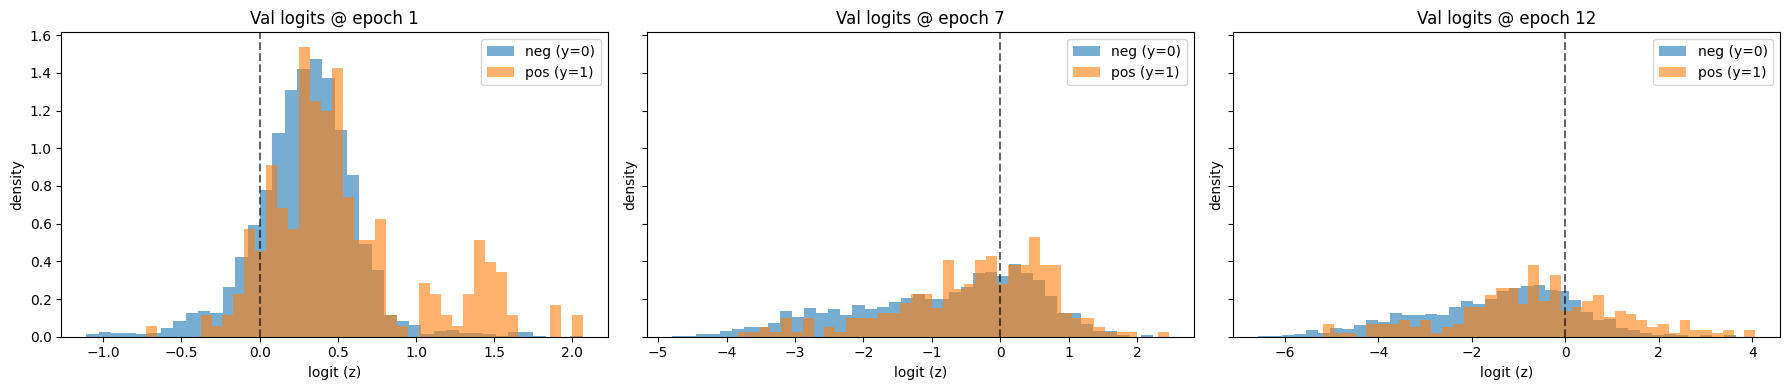

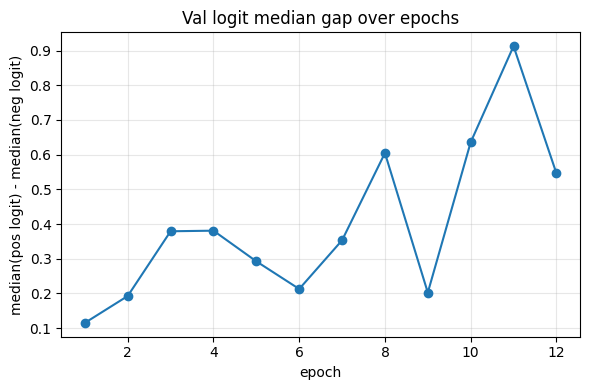

Training model 8ee9b35b-61e8-467f-9025-94ed4e3b8d9a
Before training - Val Loss 1.1206 | Val AUROC 0.6058 | Val AUPR 0.2369
EPOCH 1 - Train Loss 1.2290 | Val Loss 0.5844 | Val AUROC 0.5819 | Val AUPR 0.2003
EPOCH 2 - Train Loss 1.0952 | Val Loss 0.6106 | Val AUROC 0.5991 | Val AUPR 0.2300
EPOCH 3 - Train Loss 1.0119 | Val Loss 0.7240 | Val AUROC 0.6697 | Val AUPR 0.2921
EPOCH 4 - Train Loss 1.0135 | Val Loss 0.5922 | Val AUROC 0.6063 | Val AUPR 0.2384
EPOCH 5 - Train Loss 0.9650 | Val Loss 0.7198 | Val AUROC 0.6098 | Val AUPR 0.2372
EPOCH 6 - Train Loss 0.8986 | Val Loss 0.5951 | Val AUROC 0.5696 | Val AUPR 0.2068
EPOCH 7 - Train Loss 0.8845 | Val Loss 0.5556 | Val AUROC 0.5539 | Val AUPR 0.1937
EPOCH 8 - Train Loss 0.7646 | Val Loss 0.5472 | Val AUROC 0.5838 | Val AUPR 0.2051
EPOCH 9 - Train Loss 0.7107 | Val Loss 0.6139 | Val AUROC 0.6574 | Val AUPR 0.2757
EPOCH 10 - Train Loss 0.5943 | Val Loss 0.6191 | Val AUROC 0.6192 | Val AUPR 0.2428
EPOCH 11 - Train Loss 0.5272 | Val Loss 0.6009

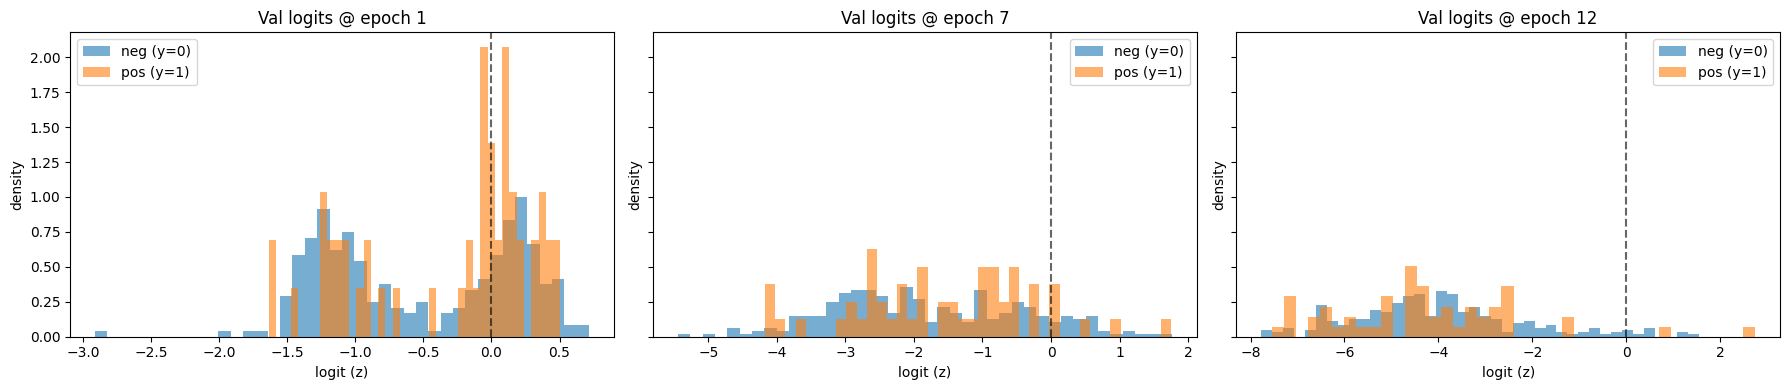

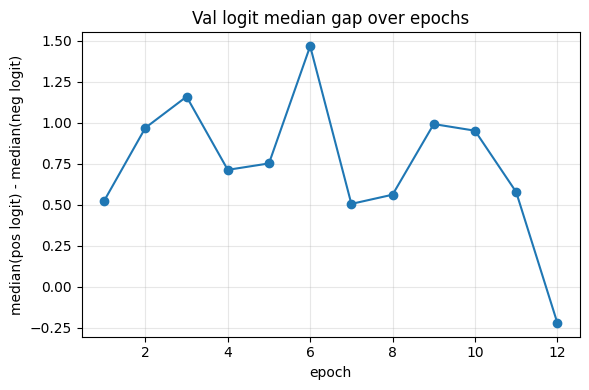

Training model 8ee9b35b-61e8-467f-9025-94ed4e3b8d9a
Before training - Val Loss 0.7167 | Val AUROC 0.6781 | Val AUPR 0.1806
EPOCH 1 - Train Loss 1.2163 | Val Loss 0.8872 | Val AUROC 0.6139 | Val AUPR 0.1783
EPOCH 2 - Train Loss 1.0860 | Val Loss 1.0347 | Val AUROC 0.5772 | Val AUPR 0.1411
EPOCH 3 - Train Loss 1.0448 | Val Loss 0.9370 | Val AUROC 0.5685 | Val AUPR 0.1534
EPOCH 4 - Train Loss 0.9741 | Val Loss 0.6829 | Val AUROC 0.6046 | Val AUPR 0.1795
EPOCH 5 - Train Loss 0.9353 | Val Loss 0.6086 | Val AUROC 0.5252 | Val AUPR 0.1174
EPOCH 6 - Train Loss 0.8626 | Val Loss 0.8363 | Val AUROC 0.6039 | Val AUPR 0.1778
EPOCH 7 - Train Loss 0.7954 | Val Loss 0.7682 | Val AUROC 0.6184 | Val AUPR 0.1625
EPOCH 8 - Train Loss 0.7403 | Val Loss 1.3778 | Val AUROC 0.6084 | Val AUPR 0.1668
EPOCH 9 - Train Loss 0.7178 | Val Loss 0.5637 | Val AUROC 0.5599 | Val AUPR 0.1641
EPOCH 10 - Train Loss 0.6064 | Val Loss 0.7163 | Val AUROC 0.5988 | Val AUPR 0.1437
EPOCH 11 - Train Loss 0.4717 | Val Loss 0.6260

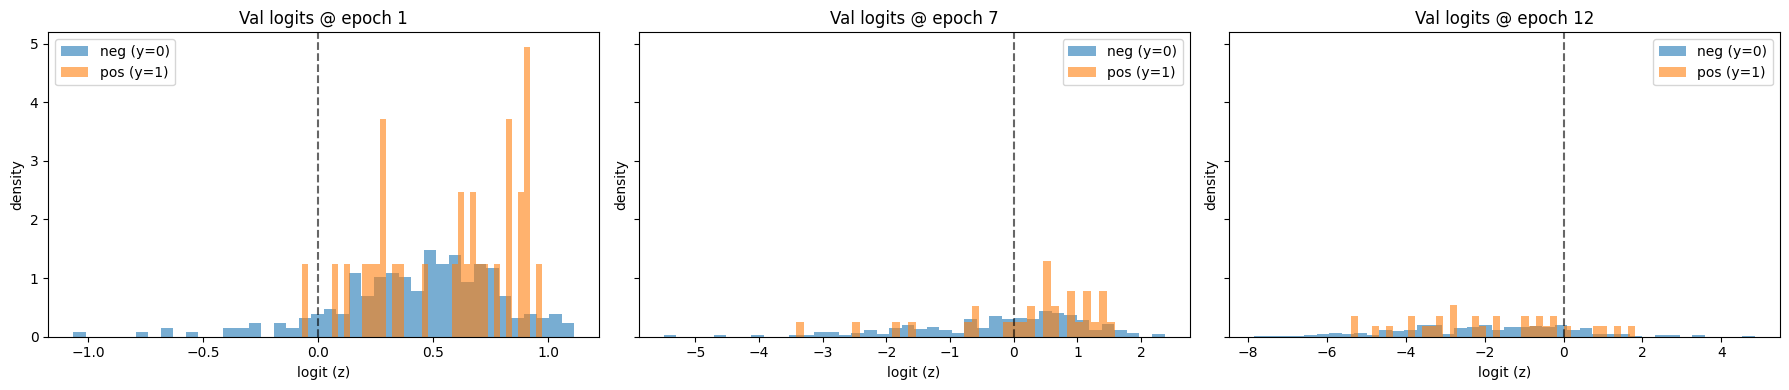

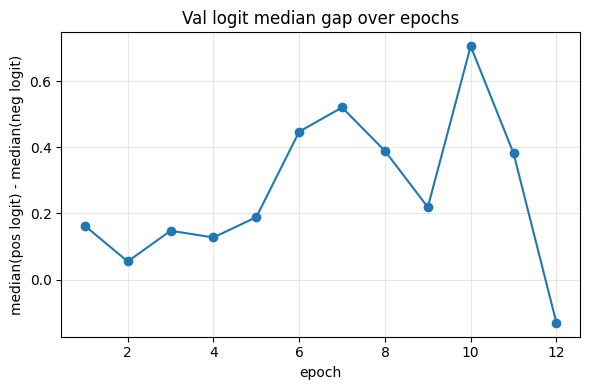

Training model 8ee9b35b-61e8-467f-9025-94ed4e3b8d9a
Before training - Val Loss 0.5645 | Val AUROC 0.5779 | Val AUPR 0.1244
EPOCH 1 - Train Loss 1.1847 | Val Loss 1.0207 | Val AUROC 0.4997 | Val AUPR 0.1189
EPOCH 2 - Train Loss 1.0666 | Val Loss 0.5166 | Val AUROC 0.5301 | Val AUPR 0.0768
EPOCH 3 - Train Loss 1.0360 | Val Loss 1.0355 | Val AUROC 0.5106 | Val AUPR 0.0790
EPOCH 4 - Train Loss 1.0155 | Val Loss 0.9720 | Val AUROC 0.5503 | Val AUPR 0.0799
EPOCH 5 - Train Loss 0.9732 | Val Loss 0.7227 | Val AUROC 0.5484 | Val AUPR 0.0852
EPOCH 6 - Train Loss 0.9022 | Val Loss 0.6946 | Val AUROC 0.5215 | Val AUPR 0.0758
EPOCH 7 - Train Loss 0.8348 | Val Loss 0.7067 | Val AUROC 0.4871 | Val AUPR 0.0818
EPOCH 8 - Train Loss 0.7613 | Val Loss 0.5710 | Val AUROC 0.5194 | Val AUPR 0.0758
EPOCH 9 - Train Loss 0.6719 | Val Loss 0.6414 | Val AUROC 0.5554 | Val AUPR 0.0922
EPOCH 10 - Train Loss 0.5874 | Val Loss 0.4902 | Val AUROC 0.4820 | Val AUPR 0.0707
EPOCH 11 - Train Loss 0.4734 | Val Loss 0.5969

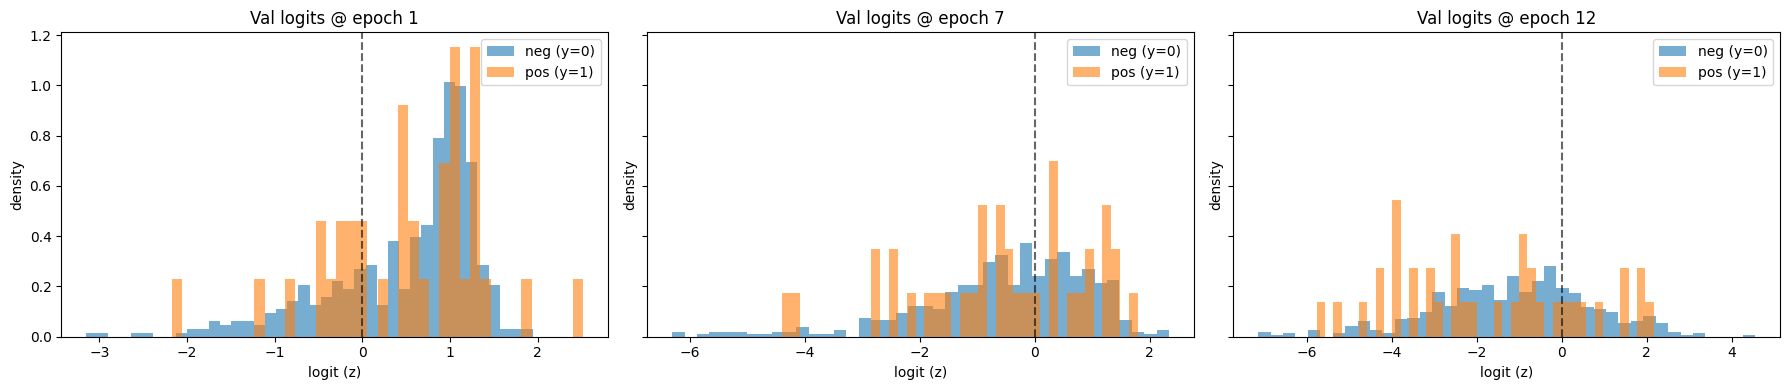

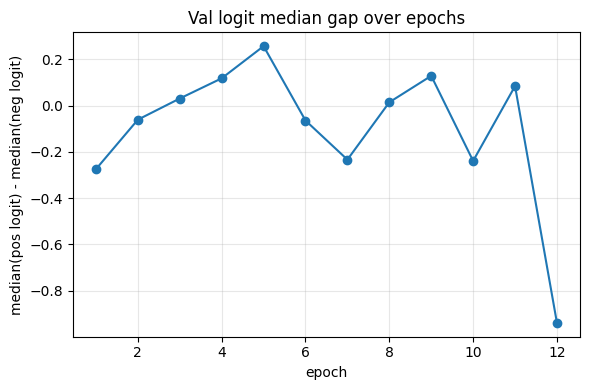

Training model 8ee9b35b-61e8-467f-9025-94ed4e3b8d9a
Before training - Val Loss 0.8068 | Val AUROC 0.5047 | Val AUPR 0.1241
EPOCH 1 - Train Loss 1.1940 | Val Loss 1.0085 | Val AUROC 0.5548 | Val AUPR 0.1311
EPOCH 2 - Train Loss 1.0559 | Val Loss 1.2511 | Val AUROC 0.5680 | Val AUPR 0.2120
EPOCH 3 - Train Loss 1.0376 | Val Loss 0.8149 | Val AUROC 0.5653 | Val AUPR 0.2391
EPOCH 4 - Train Loss 0.9569 | Val Loss 0.5761 | Val AUROC 0.5109 | Val AUPR 0.1487
EPOCH 5 - Train Loss 0.9381 | Val Loss 0.6212 | Val AUROC 0.5567 | Val AUPR 0.1810
EPOCH 6 - Train Loss 0.8810 | Val Loss 0.3760 | Val AUROC 0.5715 | Val AUPR 0.1919
EPOCH 7 - Train Loss 0.7929 | Val Loss 0.4517 | Val AUROC 0.5692 | Val AUPR 0.1492
EPOCH 8 - Train Loss 0.7520 | Val Loss 0.5747 | Val AUROC 0.5862 | Val AUPR 0.1622
EPOCH 9 - Train Loss 0.6616 | Val Loss 1.5461 | Val AUROC 0.5264 | Val AUPR 0.1864
EPOCH 10 - Train Loss 0.6621 | Val Loss 0.4146 | Val AUROC 0.5668 | Val AUPR 0.2374
EPOCH 11 - Train Loss 0.4941 | Val Loss 0.5927

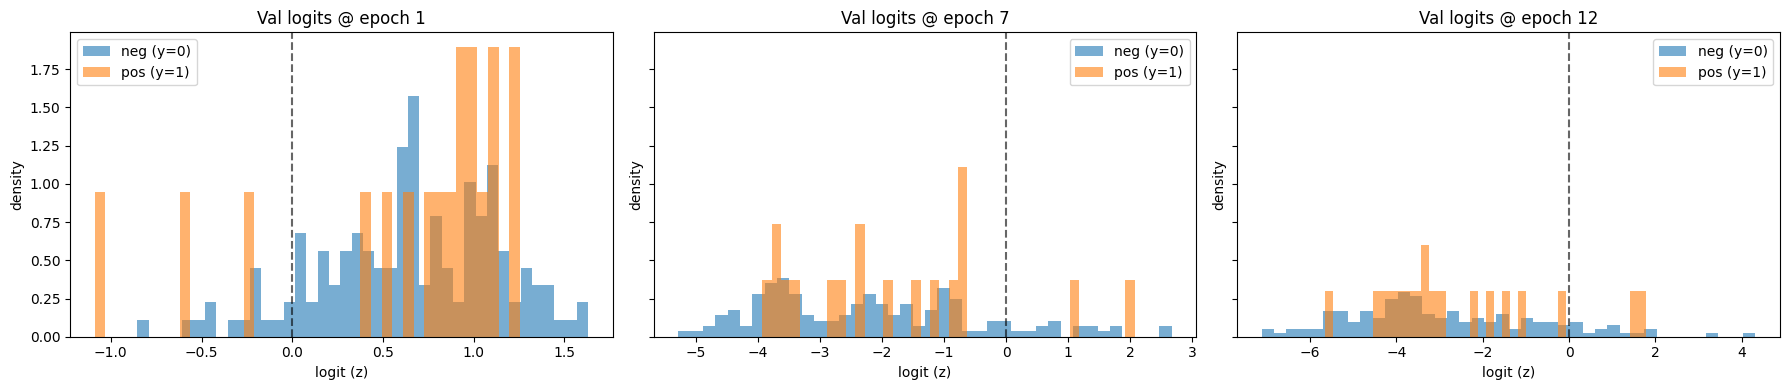

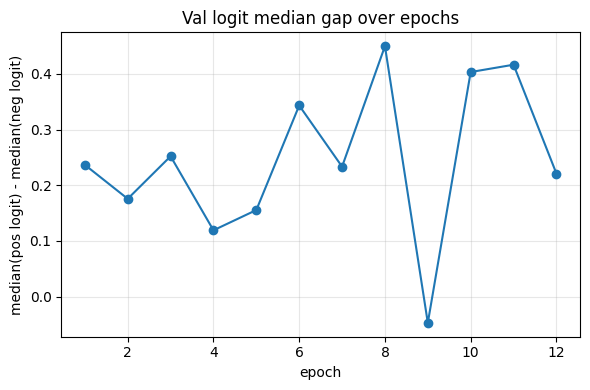

In [28]:
batch_size = 10
learning_rate = 2e-5
EPOCHS = 12
g = torch.Generator().manual_seed(SEED)

# login once (env var preferred)
if use_wandb:
    import wandb
    wandb.login()

class PairListDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        b = torch.as_tensor(b, dtype=torch.float32)
        t = torch.as_tensor(t, dtype=torch.float32)
        y = torch.tensor(float(y), dtype=torch.float32)
        return b, t, y

ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
# model.train()

for i in range(len(cv_splits)):
    # NEW model per split
    model = MiniCLIP_w_transformer_crossattn()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # validation
    val_targets = cv_splits[i][0]
    val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
    val_binders = [ALL_btl[idx] for idx in val_idx]
    val_binders = PairListDataset(val_binders)

    # training
    train_targets = cv_splits[i][1]
    train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
    train_binders = [ALL_btl[idx] for idx in train_idx]
    train_binders = PairListDataset(train_binders)

    # loaders
    ### no weighting
    train_loader   = DataLoader(train_binders, batch_size=20, shuffle=True)
    val_loader   = DataLoader(val_binders,   batch_size=20, shuffle=False, drop_last = False)

    pos = len([int(i[2].numpy()) for i in train_binders if int(i[2].numpy()) == 1])
    neg = len([int(i[2].numpy()) for i in train_binders if int(i[2].numpy()) == 0])
    pos_weight = torch.tensor(neg / max(pos, 1))

    # accelerator
    accelerator = Accelerator()
    device = accelerator.device
    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    # wandb
    # if use_wandb:
    #     run = wandb.init(
    #         project="FT_on_meta_weighting",
    #         name=f"split{i+1}_Loss_pos_weight",
    #         group="cv_splits",
    #         config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
    #                 "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
    #     )
    #     wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
    # else:
    #     run = None

    # train
    training_wrapper = TrainWrapper_MetaAnal(
        model=model,
        training_loader=train_loader,
        validation_loader=val_loader,
        test_dataset=val_binders,   # ok if you truly want “full val”
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        pos_weight = pos_weight,
        runID=runID,
        device=device,
        model_save_steps=model_save_steps,
        model_save_path=trained_model_dir,
        v=True,
        wandb_tracker=False,
        split_id=i+1
    )
    training_wrapper.train_model()

    # cleanup between splits
    # if use_wandb:
    #     wandb.finish()
    del training_wrapper, model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    try:
        accelerator.free_memory()
    except AttributeError:
        pass

In [ ]:
results_lists = {
  "class_w": {
    "Fold1": {
      "AUROC": [0.5554, 0.6577, 0.6578, 0.6713, 0.6645, 0.6333],
      "AUPR":  [0.1251, 0.2138, 0.2137, 0.2330, 0.2501, 0.2206],
    },
    "Fold2": {
      "AUROC": [0.6068, 0.6123, 0.5477, 0.6103, 0.5774, 0.5651],
      "AUPR":  [0.2373, 0.2166, 0.2431, 0.2382, 0.2077, 0.2183],
    },
    "Fold3": {
      "AUROC": [0.6763, 0.6303, 0.6413, 0.6031, 0.6344, 0.5109],
      "AUPR":  [0.1795, 0.2207, 0.2023, 0.1702, 0.2134, 0.1392],
    },
    "Fold4": {
      "AUROC": [0.5781, 0.5438, 0.5277, 0.5013, 0.5152, 0.4682],
      "AUPR":  [0.1247, 0.0821, 0.0761, 0.0808, 0.0847, 0.0698],
    },
    "Fold5": {
      "AUROC": [0.5035, 0.4592, 0.5350, 0.5750, 0.5342, 0.5458],
      "AUPR":  [0.1242, 0.1989, 0.1831, 0.1947, 0.1537, 0.1803],
    },
  },

  "class_target_w": {
    "Fold1": {
      "AUROC": [0.5554, 0.6583, 0.5939, 0.5873, 0.6199, 0.6047],
      "AUPR":  [0.1251, 0.1969, 0.2156, 0.2185, 0.1636, 0.1930],
    },
    "Fold2": {
      "AUROC": [0.6068, 0.4950, 0.5602, 0.5400, 0.5418, 0.4352],
      "AUPR":  [0.2373, 0.1594, 0.1949, 0.1823, 0.1962, 0.1650],
    },
    "Fold3": {
      "AUROC": [0.6763, 0.6361, 0.5999, 0.6562, 0.6062, 0.5858],
      "AUPR":  [0.1795, 0.1865, 0.1435, 0.1802, 0.1776, 0.1603],
    },
    "Fold4": {
      "AUROC": [0.5781, 0.6017, 0.5515, 0.5456, 0.5156, 0.5471],
      "AUPR":  [0.1247, 0.0894, 0.0812, 0.0736, 0.0723, 0.0772],
    },
    "Fold5": {
      "AUROC": [0.5035, 0.5385, 0.5260, 0.6014, 0.5637, 0.5882],
      "AUPR":  [0.1242, 0.2128, 0.1613, 0.2095, 0.2235, 0.2192],
    },
  },

  "loss_w": {
    "Fold1": {
      "AUROC": [0.5554, 0.5977, 0.6268, 0.6730, 0.6777, 0.6310],
      "AUPR":  [0.1251, 0.2153, 0.2230, 0.2472, 0.2646, 0.2213],
    },
    "Fold2": {
      "AUROC": [0.6068, 0.6178, 0.6317, 0.6403, 0.6447, 0.5810],
      "AUPR":  [0.2373, 0.2321, 0.2488, 0.2495, 0.2814, 0.2185],
    },
    "Fold3": {
      "AUROC": [0.6763, 0.5627, 0.6095, 0.6191, 0.5996, 0.6208],
      "AUPR":  [0.1795, 0.1348, 0.1636, 0.2071, 0.1909, 0.1671],
    },
    "Fold4": {
      "AUROC": [0.5781, 0.5210, 0.5616, 0.5517, 0.5361, 0.5512],
      "AUPR":  [0.1247, 0.0862, 0.1057, 0.0773, 0.0790, 0.0758],
    },
    "Fold5": {
      "AUROC": [0.5035, 0.5361, 0.5198, 0.5493, 0.5291, 0.5723],
      "AUPR":  [0.1242, 0.1759, 0.1393, 0.1554, 0.1464, 0.1445],
    },
  },

  "order": ["Before", "E1", "E2", "E3", "E4", "E5"],
}

In [ ]:
metrics_class_w = {
    "Fold1": {
      "AUROC": [0.5554, 0.6577, 0.6578, 0.6713, 0.6645, 0.6333],
      "AUPR":  [0.1251, 0.2138, 0.2137, 0.2330, 0.2501, 0.2206],
    },
    "Fold2": {
      "AUROC": [0.6068, 0.6123, 0.5477, 0.6103, 0.5774, 0.5651],
      "AUPR":  [0.2373, 0.2166, 0.2431, 0.2382, 0.2077, 0.2183],
    },
    "Fold3": {
      "AUROC": [0.6763, 0.6303, 0.6413, 0.6031, 0.6344, 0.5109],
      "AUPR":  [0.1795, 0.2207, 0.2023, 0.1702, 0.2134, 0.1392],
    },
    "Fold4": {
      "AUROC": [0.5781, 0.5438, 0.5277, 0.5013, 0.5152, 0.4682],
      "AUPR":  [0.1247, 0.0821, 0.0761, 0.0808, 0.0847, 0.0698],
    },
    "Fold5": {
      "AUROC": [0.5035, 0.4592, 0.5350, 0.5750, 0.5342, 0.5458],
      "AUPR":  [0.1242, 0.1989, 0.1831, 0.1947, 0.1537, 0.1803],
    },
}

metrics_class_target_w = {
    "Fold1": {
      "AUROC": [0.5554, 0.6583, 0.5939, 0.5873, 0.6199, 0.6047],
      "AUPR":  [0.1251, 0.1969, 0.2156, 0.2185, 0.1636, 0.1930],
    },
    "Fold2": {
      "AUROC": [0.6068, 0.4950, 0.5602, 0.5400, 0.5418, 0.4352],
      "AUPR":  [0.2373, 0.1594, 0.1949, 0.1823, 0.1962, 0.1650],
    },
    "Fold3": {
      "AUROC": [0.6763, 0.6361, 0.5999, 0.6562, 0.6062, 0.5858],
      "AUPR":  [0.1795, 0.1865, 0.1435, 0.1802, 0.1776, 0.1603],
    },
    "Fold4": {
      "AUROC": [0.5781, 0.6017, 0.5515, 0.5456, 0.5156, 0.5471],
      "AUPR":  [0.1247, 0.0894, 0.0812, 0.0736, 0.0723, 0.0772],
    },
    "Fold5": {
      "AUROC": [0.5035, 0.5385, 0.5260, 0.6014, 0.5637, 0.5882],
      "AUPR":  [0.1242, 0.2128, 0.1613, 0.2095, 0.2235, 0.2192],
    },
  }

metrics_loss_w = {
    "Fold1": {
      "AUROC": [0.5554, 0.5977, 0.6268, 0.6730, 0.6777, 0.6310],
      "AUPR":  [0.1251, 0.2153, 0.2230, 0.2472, 0.2646, 0.2213],
    },
    "Fold2": {
      "AUROC": [0.6068, 0.6178, 0.6317, 0.6403, 0.6447, 0.5810],
      "AUPR":  [0.2373, 0.2321, 0.2488, 0.2495, 0.2814, 0.2185],
    },
    "Fold3": {
      "AUROC": [0.6763, 0.5627, 0.6095, 0.6191, 0.5996, 0.6208],
      "AUPR":  [0.1795, 0.1348, 0.1636, 0.2071, 0.1909, 0.1671],
    },
    "Fold4": {
      "AUROC": [0.5781, 0.5210, 0.5616, 0.5517, 0.5361, 0.5512],
      "AUPR":  [0.1247, 0.0862, 0.1057, 0.0773, 0.0790, 0.0758],
    },
    "Fold5": {
      "AUROC": [0.5035, 0.5361, 0.5198, 0.5493, 0.5291, 0.5723],
      "AUPR":  [0.1242, 0.1759, 0.1393, 0.1554, 0.1464, 0.1445],
    },
  }

In [ ]:
epochs = list(range(1, 7))

plt.figure(figsize=(10, 4))

# -----------------------
# Subplot 1: AUROC
# -----------------------
plt.subplot(1, 2, 1)
for fold, vals in metrics_loss_w.items():
    plt.plot(epochs, vals["AUROC"], marker='o', label=fold)

plt.title("Fine-tunning on 'meta-analysis' dataset \n Loss weighting")
plt.xlabel("Epoch")
plt.ylabel("AUROC")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend()

# -----------------------
# Subplot 2: AUPR
# -----------------------
plt.subplot(1, 2, 2)
for fold, vals in metrics_loss_w.items():
    plt.plot(epochs, vals["AUPR"], marker='o', label=fold)

plt.title("Fine-tunning on 'meta-analysis' dataset \n Loss weighting")
plt.xlabel("Epoch")
plt.ylabel("AUPR")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from scipy import stats
from itertools import combinations

SCHEMES = ["class_w", "class_target_w", "loss_w"]
METRICS = ["AUROC", "AUPR"]
EPOCH_IDX = [1, 2, 3, 4, 5]  # ignore index 0 ("Before")
ALPHA = 0.05

def per_fold_epoch_mean(results, scheme, metric):
    """Return a dict: fold -> mean over E1..E5 for the given scheme/metric."""
    fold_means = {}
    for fold, vals in results[scheme].items():
        scores = vals[metric]
        # scores[0] is "Before", so average over indices 1..5
        epoch_scores = [scores[i] for i in range(1, 6)]
        fold_means[fold] = float(np.mean(epoch_scores))
    return fold_means

def collect_means_df(results):
    """DataFrame with columns: scheme, fold, AUROC_mean, AUPR_mean (averaged over E1..E5)."""
    rows = []
    # intersect folds across schemes just in case
    folds_sets = [set(results[s].keys()) for s in SCHEMES]
    common_folds = sorted(set.intersection(*folds_sets))
    for scheme in SCHEMES:
        auroc_means = per_fold_epoch_mean(results, scheme, "AUROC")
        aupr_means  = per_fold_epoch_mean(results, scheme, "AUPR")
        for fold in common_folds:
            rows.append({
                "scheme": scheme,
                "fold": fold,
                "AUROC_mean": auroc_means[fold],
                "AUPR_mean": aupr_means[fold],
            })
    return pd.DataFrame(rows)

def paired_tests_with_bonferroni(df, metric):
    """Paired t-tests across folds for the given metric (e.g., 'AUROC_mean')."""
    metric_col = f"{metric}_mean"
    # build fold-aligned vectors per scheme
    fold_order = sorted(df["fold"].unique())
    vectors = {
        scheme: df[df["scheme"] == scheme].set_index("fold").loc[fold_order, metric_col].values
        for scheme in SCHEMES
    }
    # 3 pairwise comparisons
    pairs = list(combinations(SCHEMES, 2))
    m = len(pairs)  # Bonferroni factor = 3
    out = []
    for a, b in pairs:
        x, y = vectors[a], vectors[b]
        tstat, p_raw = stats.ttest_rel(x, y, nan_policy="raise")
        p_adj = min(p_raw * m, 1.0)
        # simple paired Cohen's d (dz)
        diff = x - y
        dz = diff.mean() / (diff.std(ddof=1) + 1e-12)
        out.append({
            "metric": metric,
            "comparison": f"{a} vs {b}",
            "n_folds": len(x),
            "t": tstat,
            "p_raw": p_raw,
            "p_bonf": p_adj,
            "signif_0.05": p_adj < ALPHA,
            "mean_a": x.mean(),
            "mean_b": y.mean(),
            "mean_diff_a_minus_b": (x - y).mean(),
            "cohens_dz": dz,
        })
    return pd.DataFrame(out).sort_values("p_bonf")

def descriptive_table(df):
    """Per-scheme summary of fold-averaged means (mean ± std across folds)."""
    summaries = []
    for scheme, g in df.groupby("scheme"):
        summaries.append({
            "scheme": scheme,
            "AUROC_mean_over_folds": g["AUROC_mean"].mean(),
            "AUROC_std_over_folds": g["AUROC_mean"].std(ddof=1),
            "AUPR_mean_over_folds": g["AUPR_mean"].mean(),
            "AUPR_std_over_folds": g["AUPR_mean"].std(ddof=1),
        })
    return pd.DataFrame(summaries).sort_values("AUROC_mean_over_folds", ascending=False)

# ---- Run analysis ----
df_means = collect_means_df(results_lists)

desc = descriptive_table(df_means)
print("\nPer-scheme descriptive stats (averaged over E1..E5, then summarized across folds):")
print(desc.to_string(index=False))

auroc_tests = paired_tests_with_bonferroni(df_means, "AUROC")
aupr_tests  = paired_tests_with_bonferroni(df_means, "AUPR")

print("\nPaired t-tests with Bonferroni (AUROC):")
print(auroc_tests.to_string(index=False))

print("\nPaired t-tests with Bonferroni (AUPR):")
print(aupr_tests.to_string(index=False))
